# Plot TNG RPS plots
## Written by Eric Rohr

In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
random.seed(1)
%matplotlib notebook 

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

In [2]:
### set global variables and plotting kwargs
mass_binwidth = 0.25
time_binwidth = 0.5

NGaussSmooth = 1000

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker=r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
plot_kwargs         = dict(fillstyle='none', ms=3, mew=0.75)
vline_kwargs        = dict(marker='None', ls='-', zorder=1, alpha=0.5, lw=1.0)
median_kwargs       = vline_kwargs.copy()
median_kwargs['lw'] = 2.0
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
muz0_label_words = r'Mass Ratio $[\mu(z=0)]$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'\# Galaxies (Branches)' 

tau0_RPS_tot_key = 'CosmicTime_tau_RPS_tot0'
tau90_RPS_tot_key = 'CosmicTime_tau_RPS_tot90'
tau100_RPS_tot_key = 'CosmicTime_tau_RPS_tot100'
tstrip_RPS_tot_key = 'Tstrip_tau_RPS_tot_tau0-tau100'

tau0_RPS_tot_label = r'Cosmic Time at Infall [$\tau_0$] [Gyr]'
tau90_RPS_tot_label = r'Cosmic Time at $\tau_{90}$ [RPS tot] [Gyr]'
tau100_RPS_tot_label = r'Cosmic Time at $\tau_{100}$ [Gyr]'
tstrip_RPS_tot_label = r'$\tau_{\rm RPS} \equiv \tau_{100} - \tau_{0}$ [Gyr]'

tau0_label_alt = r'RPS onset [$\tau_0$] [Gyr]'
tau100_label_alt = r'RPS end [$\tau_{100}$] [Gyr]'

tau0_key = tau0_RPS_tot_key
infall_key = tau0_key
tau0_label = tau0_RPS_tot_label
infall_label = tau0_label
tau100_key = tau100_RPS_tot_key
tau100_label = tau100_RPS_tot_label
tstrip_key = tstrip_RPS_tot_key
tstrip_label = tstrip_RPS_tot_label
tstrip_label_long = r'Total RPS Duration [$\tau_{\rm RPS} \equiv \tau_{100} - \tau_{0}$] [Gyr]'

tau0_RPS_est_key = 'CosmicTime_tau_RPS_est0'
tau90_RPS_est_key = 'CosmicTime_tau_RPS_est90'
tau100_RPS_est_key = 'CosmicTime_tau_RPS_est100'
tstrip_RPS_est_key = 'Tstrip_tau_RPS_est_tau0-tau100'

tau0_RPS_est_label = r'Cosmic Time at $\tau_0$ [RPS est] [Gyr]'
tau90_RPS_est_label = r'Cosmic Time at $\tau_{90}$ [RPS est] [Gyr]'
tau100_RPS_est_label = r'Cosmic Time at $\tau_{100}$ [RPS est] [Gyr]'
tstrip_RPS_est_label = r'$\tau_{\rm RPS}$ [RPS est] [Gyr]'

tau0_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS0'
tau100_RPS_sRPS_key = 'CosmicTime_tau_RPS_sRPS100'
tstrip_RPS_sRPS_key = 'Tstrip_tau_RPS_sRPS_tau0-tau100'

tau0_RPS_sRPS_label = r'Cosmic Time at $\tau_0$ [RPS sRPS] [Gyr]'
tau100_RPS_sRPS_label = r'Cosmic Time at $\tau_{100}$ [RPS sRPS] [Gyr]'
tstrip_RPS_sRPS_label = r'$\tau_{\rm RPS}$ [RPS sRPS] [Gyr]'

d0_RPS_tot_key = 'HostCentricDistance_norm_tau_RPS_tot0'
d0_RPS_tot_label = r'Distance to $z=0$ Host at infall $[R_{\rm 200c}^{\rm host}({\rm infall})]$'

fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SCGM_infall_key = 'SubhaloColdGasMass_tau_RPS_tot0'
SCGM_infall_label = r'$M_{\rm ColdGas}^{\rm sat}(\tau_0)$'

Napopass_tau100_key = 'Napopass_tau_RPS_tot100'
Napopass_tau100_label = r'Number of Orbits'

direc_list = ['../Figures/Tracers/TNG50-1/SummaryPlots/']
direc_PP = '../Figures/Tracers/TNG50-1/PaperPlots/'
direc_list = [direc_PP]


In [3]:
# define plotting labels and kwargs for each taudcit_key, gasz0_key combination

jel_key = 'jellyfish'
non_key = 'nonjellyf'
ins_key = 'inspected'
gen_key = 'z0satellites'
taudict_keys = [jel_key, non_key, ins_key, gen_key]

jel_label = 'Jellyfish'
non_label = 'Non-Jellyfish'
ins_label = 'Inspected'
gen_label = r'$z=0$ Satellites'
taudict_labels = [jel_label, non_label, ins_label]
taudict_labels_dict = {jel_key:jel_label, non_key:non_label, ins_key:ins_label, gen_key:gen_label}

tot_key = 'tot'
gas_key = 'gas'
nogas_key = 'nogas'
gasz0_keys = [tot_key, gas_key, nogas_key]

tot_label = 'All'
gas_label = r'$M_{\rm ColdGas}^{\rm sat}(z=0) > 4\times10^{4}\, {\rm M_\odot}$'
nogas_label = r'$M_{\rm ColdGas}^{\rm sat}(z=0) < 4\times10^{4}\, {\rm M_\odot}$'
gasz0_labels = [tot_label, gas_label, nogas_label]
gasz0_labels_dict = {tot_key:tot_label, gas_key:gas_label, nogas_key:nogas_label}

### define some general plotting parameters for each taudict_key, gasz0_key combination
### general colorscheme:
### jellyfish: green (for green valley galaxies, and images are typically green, blue and yellow)
### nonjellyf: purple (could be starforming and blue or quiescent and red)
### inspected: black 
### gasz0: blue, because they still have gas and are likely star forming
### nogasz0: red, because they have no gas and are quenched
### tot: the same color as standard

histkwargs_jel = dict(**hist_kwargs, color='tab:green', lw=2.5, zorder=2.2)
histkwargs_non = dict(**hist_kwargs, color='tab:purple', lw=2.0, zorder=2.1)
histkwargs_ins = dict(**hist_kwargs, color='tab:gray', lw=3.0, zorder=2.0)
histkwargs_gen = dict(**hist_kwargs, color='silver', lw=3.5, zorder=1.9)
histkwargs_gen['histtype'] = 'bar'
histkwargs_dict_temp = {jel_key:histkwargs_jel, non_key:histkwargs_non, ins_key:histkwargs_ins, gen_key:histkwargs_gen}

histkwargs_dict = {}
for taudict_key in taudict_keys:
    histkwargs_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        histkwargs_dict[taudict_key][gasz0_key] = histkwargs_dict_temp[taudict_key].copy()
    histkwargs_dict[taudict_key][gas_key]['color'] = 'tab:blue'
    histkwargs_dict[taudict_key][nogas_key]['color'] = 'tab:red'


cmaps_dict_temp = {jel_key:mpl.cm.get_cmap('Greens'),
                   non_key:mpl.cm.get_cmap('Purples'),
                   ins_key:mpl.cm.get_cmap('Greys'),
                   gen_key:mpl.cm.get_cmap('Greys')}
cmaps_dict = {}
for taudict_key in taudict_keys:
    cmaps_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        cmaps_dict[taudict_key][gasz0_key] = cmaps_dict_temp[taudict_key].copy()
    cmaps_dict[taudict_key][gas_key] = mpl.cm.get_cmap('Blues')
    cmaps_dict[taudict_key][nogas_key] = mpl.cm.get_cmap('Reds')
    
    
## define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
sim = 'TNG50-1'
M200cz0_bins = [11.99, 12.5, 13.5, 14.3] 
Mstarz0_bins = [8.0, 9.0, 10.0, 11.0]
SCGM_infall_bins = [7.98, 9.5, 10., 11.0]
tau0_bins = [5.0, 7.5, 10.0, 12.5]
Norbit_bins = [0, 1, 2, 6]

tstrip_histkwargs_dict = {}
histkwargs_list_key = 'histkwargs_list'

# M200cz0
tstrip_histkwargs_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                           savelabel=r'm200cz0', bins=M200cz0_bins)

histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
histkwargs_list[0] = dict(**hist_kwargs, color='orangered', lw=1.5, zorder=1.05)
histkwargs_list[1] = dict(**hist_kwargs, color='red', lw=2.5, zorder=1.15)
histkwargs_list[2] = dict(**hist_kwargs, color='darkred', lw=3.5, zorder=1.25)
tstrip_histkwargs_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
    
# SCGM(infall)
histkwargs_list    = [{}] * (len(SCGM_infall_bins) - 1)
tstrip_histkwargs_dict[SCGM_infall_key] = dict(key=SCGM_infall_key, label=SCGM_infall_label,
                                               savelabel=r'SCGMinfall', bins=SCGM_infall_bins)
histkwargs_list[0] = dict(**hist_kwargs, color='darkorange', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='orange', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='wheat', lw=1.0)
tstrip_histkwargs_dict[SCGM_infall_key][histkwargs_list_key] = histkwargs_list

# Mstarz0
histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)

tstrip_histkwargs_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                           savelabel=r'mstarz0', bins=Mstarz0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkmagenta', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='mediumpurple', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='violet', lw=1.0)
tstrip_histkwargs_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
      
# tau0_infall 
histkwargs_list  = [{}] * (len(tau0_bins) - 1)

tstrip_histkwargs_dict[tau0_key] = dict(key=tau0_key, label=tau0_label,
                                        savelabel='infalltime', bins=tau0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkgreen', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='limegreen', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='palegreen', lw=1.0)
tstrip_histkwargs_dict[tau0_key][histkwargs_list_key] = histkwargs_list

# Nubmer of completed orbits (== Number of apocenter passes)
tstrip_histkwargs_dict[Napopass_tau100_key] = {histkwargs_list_key:histkwargs_list.copy()}
tstrip_histkwargs_dict[Napopass_tau100_key]['bins'] = Norbit_bins
tstrip_histkwargs_dict[Napopass_tau100_key]['savelabel'] = 'Norbit'
tstrip_histkwargs_dict[Napopass_tau100_key]['label'] = Napopass_tau100_label
       
# add these dictionaries to the class
tstrip_histbins_dict = {tstrip_key:tstrip_histkwargs_dict}


In [4]:
class TNGSim:
    
    def __init__(self, sim=sim, zooniverse=True, taudict_key=jel_key, gasz0_key=tot_key,
                 tstrip_histbins_dict=tstrip_histbins_dict):
        """
        Initialize the TNGsim class.
        sim == 'TNG50-1' 
        taudict_key == jel_key, non_key, or ins_key
        gasz0_key == tot_key, gas_key, nogas_key
        M200cz0_bins, Mstarz0_bins should each be length 4, including all bin edges
        """ 
        self.sim  = sim
        self.zooniverse = zooniverse
        self.taudict_key = taudict_key
        self.gasz0_key = gasz0_key
        self.M200cz0_bins= M200cz0_bins
        self.Mstarz0_bins = Mstarz0_bins
        
        self.sim_label = sim[:-2]
        
        self.taudict_label = taudict_labels_dict[taudict_key]
        
        self.gasz0_label = gasz0_labels_dict[gasz0_key]
                       
        # load the tau dictionary 
        self.tau_dict = load_taudict(self, zooniverse=zooniverse, key=taudict_key, gasz0_key=gasz0_key)
        
        self.histkwargs = histkwargs_dict[taudict_key][gasz0_key]
        self.cmap = cmaps_dict[taudict_key][gasz0_key]
        self.plotkwargs = dict(**plot_kwargs, color=self.histkwargs['color'])
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        self.tstrip_histbins_dict = tstrip_histbins_dict
        
        self.save_label = self.sim + '_' + taudict_key + '_' + gasz0_key
        self.plot_label = self.sim_label + ' ' + self.taudict_label + ' ' + self.gasz0_label
        
        return

def load_taudict(Sim, zooniverse=True, key=jel_key, gasz0_key=tot_key):

    result = {}
    fname = return_taudict_fname(Sim.sim, zooniverse=zooniverse, key=key, gasz0_key=gasz0_key)
    with h5py.File('../Output/%s_subfindGRP/'%Sim.sim + fname, 'a') as f:
        group = f['Group']
        for dset_key in group.keys():
            result[dset_key] = group[dset_key][:]
        f.close()
        
    return result
    
    
def return_taudict_fname(sim='TNG50-1', zooniverse=True, key=jel_key, gasz0_key=tot_key):
    
    if zooniverse:
        fname = 'zooniverse_%s_%s_clean_tau'%(sim, key)
    else:
        fname = 'subfind_%s_clean_tau'%sim

    if gasz0_key == nogas_key:
        fname += '_nogasz0.hdf5'
    elif gasz0_key == gas_key:
        fname += '_gasz0.hdf5'
    elif gasz0_key == tot_key:
        fname += '.hdf5'
    else:
        print('Warning, gasz0_key %s not recognized. Using tot_key instead.'%(gasz0_key))
        fname += '.hdf5'
                         
    return fname
        
    
def add_redshift_sincez2(ax, label=True):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.25

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax



In [5]:
sim = 'TNG50-1'
TNG50_dict = {}
for taudict_key in taudict_keys[:-1]:
    TNG50_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        TNG50_dict[taudict_key][gasz0_key] = TNGSim(sim=sim, zooniverse=True, taudict_key=taudict_key, gasz0_key=gasz0_key, tstrip_histbins_dict=tstrip_histbins_dict)



In [6]:
TNG50_gen = TNGSim(sim=sim, zooniverse=False, taudict_key=gen_key)
TNG50_dict[gen_key] = TNG50_gen

In [7]:
### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_tracers_mass_distributions_z0(Sims, savefig=False):
    """
    Plot the 1D histograms for 6 panels defined below. Could be generalized...
    Sims should be a list of TNGSim classes, starting with the broadest possible sample (i.e., inspected, tot)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sims, axs, x_keys, x_labels, y_step=0.15)
    for ax in axs.flatten():
        ax = plot_all_logticks(ax, plot_minor_ticks=True)
    
    fig.legend(handles=legend_handels, ncol=len(Sims), bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sims[0].sim_label, title_fontsize='large', **legend_kwargs)
    
    axs[0,0].set_ylim(axs[0,0].get_ylim()[0], axs[0,0].get_ylim()[1] * 2.0)
    axs[1,0].set_ylim(axs[1,0].get_ylim()[0], axs[1,0].get_ylim()[1] * 2.0)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_massdistributions_z0.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs

def plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top',
                      plot_mask=True):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')

        ax = plot_1Dhist_panel(Sims, ax, x_key, plot_mask=plot_mask) 
                
    # generate legend handels 
    legend_handels = add_histlegend(Sims)
    
    return axs, legend_handels
 
def plot_1Dhist_panel(Sims, ax, x_key,
                      plot_mask=True):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    For the x values <= 0, there's the option either to plot them 
    at 1.0e-2 * min(x), or to omit them entirely. 
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the inspected branches to set the bins ###
    x = TNG50_dict[ins_key][tot_key].tau_dict[x_key].copy()
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if ('T' in x_key) or ('tau' in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = 0.
        x[mask] = min_plot
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key) or ('mu' in x_key):
        x_loval = 1.0e-7
        mask = x <= x_loval
        min_plot = x[~mask].min() * 1.0e-2
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
        
    dsets = []
        
    for Sim in Sims:
        # load dataset and validate
        x = Sim.tau_dict[x_key].copy()
        
        if plot_mask:
            mask = x <= x_loval
            x[mask] = min_plot
        #else:
        #    x = x[~mask]
            
        if Sim.taudict_key == jel_key or Sim.taudict_key == ins_key:
            dsets.append(x)
            add_med_ticks(ax, x, color=Sim.histkwargs['color'], errs=True, spread=False)
            
        label = Sim.gasz0_key + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs

        ax.hist(x, bins, label=label, **histkwargs)
    # finish loop over Sims
    
    # run KS test on the two distribituions
    ks = ks_2samp(dsets[0], dsets[1]).pvalue
    anderson = anderson_ksamp(dsets)
    print(x_key, ks, anderson)
        
    return ax


# code for adding median + error tick marks
def add_med_ticks(ax, dset, color='k', yval=0.90, errs=False, spread=True):
    """
    Add ticks for the median (and errors) plus 16/84th percentiles
    """
    
    med = np.median(dset)
    err = 1.25 * np.std(dset) / np.sqrt(dset.size)
    xlo = med - err
    xhi = med + err
    if xlo <= np.min(dset):
        xlo = np.min(dset)
    if xhi >= np.max(dset):
        xhi = np.max(dset)
    x16 = np.percentile(dset, 16)
    x84 = np.percentile(dset, 84)
    
    # median
    ax.plot([med, med], [yval, 1.0], lw=3, ls='-', color=color, marker='None', alpha=0.75,
            transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
    
    # error
    if errs:
        ax.fill_between([xlo, xhi], yval, 1.0, color=color, alpha=0.3,
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
    
    # 16/84 percentiles
    if spread:
        ax.fill_between([x16, x84], yval, 1.0, color=color, alpha=0.3,
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
                                    
    return ax


def add_histlegend(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        label = Sim.taudict_label + ' (%d)'%(Sim.tau_dict[M200cz0_key].size)
        # remove the data points without well defined tau_0 
        if Sim != Sims[-1]:
            N = np.where(Sim.tau_dict[infall_key] > 0)[0].size
            label = Sim.taudict_label + ' (%d)'%N
            
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


def plot_all_logticks(ax, x_axis=True, plot_minor_ticks=False):
    """
    helper function that ensures that each base 10 power is shown.
    assumes to be run on x-axis, but functions similarly for y-axis.
    """
    if x_axis:
        x_lims = ax.get_xlim()
        x_lolog = ru.ceil_to_value(np.log10(x_lims[0]), 1.0)
        x_hilog = ru.floor_to_value(np.log10(x_lims[1]), 1.0)
        Ndex = x_hilog - x_lolog + 1
        
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.xaxis.set_minor_locator(locmin)
            
    else:
        ylims = ax.get_ylim()
        y_lolog = ru.ceil_to_value(np.log10(y_lims[0]), 1.0)
        y_hilog = ru.floor_to_value(np.log10(y_lims[1]), 1.0)
        Ndex = yhilog - y_lolog + 1

        ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.yaxis.set_minor_locator(locmin)
            
    return ax

    

<IPython.core.display.Javascript object>


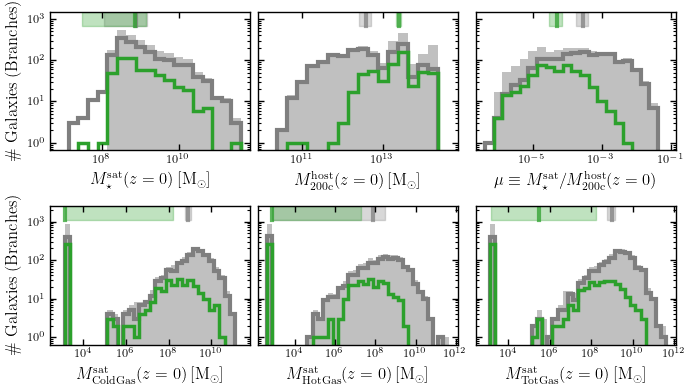

Subhalo_Mstar_Rgal_z0 0.17020732804086358 Anderson_ksampResult(statistic=1.684122009042352, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.06560311016516429)
HostGroup_M_Crit200_z0 2.1064517357618905e-52 Anderson_ksampResult(statistic=176.15151928699322, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
muz0 2.5936616072855326e-49 Anderson_ksampResult(statistic=166.48777188438586, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
SubhaloColdGasMass_z0 4.9025094328668366e-45 Anderson_ksampResult(statistic=162.72753199140135, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
SubhaloHotGasMass_z0 9.9497991391244e-31 Anderson_ksampResult(statistic=129.14234509740842, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
SubhaloGasMass_z0 8.7648430606

/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)


In [8]:
Sims = [TNG50_dict[ins_key][tot_key],
        TNG50_dict[jel_key][tot_key],
        TNG50_dict[gen_key]]

savefig=False

fig, axs = plot_tracers_mass_distributions_z0(Sims, savefig=savefig)

In [9]:
Sim = TNG50_dict[non_key][tot_key]
tau_dict = Sim.tau_dict
SCGM_infall = tau_dict[SCGM_infall_key]
good_indices = SCGM_infall >= 0

key = MTGasz0_key

dset = tau_dict[key][good_indices]
print(dset.size, dset[dset > 1.0e-4].size, dset[dset < 1.0e4].size, dset[dset < 1.0e4].size / dset.size)

key = MCGasz0_key
dset = tau_dict[key][good_indices]
print(dset.size, dset[dset > 1.0e-4].size, dset[dset < 1.0e4].size, dset[dset < 1.0e4].size / dset.size)

1031 908 123 0.11930164888457807
1031 906 125 0.12124151309408342


In [10]:
STGM_infall_key = 'SubhaloGasMass_tau_RPS_tot0'

Sim = TNG50_dict[jel_key][tot_key]
tau_dict = Sim.tau_dict
SCGM_infall = tau_dict[SCGM_infall_key]
STGM_infall = tau_dict[STGM_infall_key]
good_indices = SCGM_infall >= 0

dset = SCGM_infall[good_indices] / STGM_infall[good_indices]

mstarz0 = tau_dict[Mstarz0_key][good_indices]
indices_89 = (mstarz0 > 1.0e8) & (mstarz0 < 1.0e9)
print(np.mean(dset[indices_89]), np.median(dset[indices_89]), np.percentile(dset[indices_89], 16), np.percentile(dset[indices_89], 84))

indices_910 = (mstarz0 > 1.0e9) & (mstarz0 < 1.0e10)
print(np.mean(dset[indices_910]), np.median(dset[indices_910]), np.percentile(dset[indices_910], 16), np.percentile(dset[indices_910], 84))

print(mstarz0.size, mstarz0[mstarz0 > 1.0e10].size, mstarz0[mstarz0 > 1.0e10].size / mstarz0.size)

0.728591836918589 0.7553424271929247 0.5842426690138556 0.870668970060904
0.5855552631144788 0.5784861303311433 0.46272934854172504 0.7261866521291523
512 45 0.087890625


In [11]:
Sim = TNG50_dict[non_key][tot_key]
tau_dict = Sim.tau_dict
SCGM_infall = tau_dict[SCGM_infall_key]
good_indices = SCGM_infall >= 0

mstarz0 = tau_dict[Mstarz0_key][good_indices]

print(mstarz0.size, mstarz0[mstarz0 > 1.0e10].size, mstarz0[mstarz0 > 1.0e10].size / mstarz0.size)

1031 163 0.15809893307468478


In [12]:
tau_quench_key = 'tau_RPS_tot_quench'
tau_medpeak_quench_key = 'tau_medpeak_ColdGas_quench'
tau_infall_quench_key = 'tau_infall_ColdGas_quench'

Sim = TNG50_dict[jel_key][nogas_key]
tau_dict = Sim.tau_dict
tau_quench = tau_dict[tau_quench_key]
good_indices = tau_quench >= 0
tau_quench = tau_quench[good_indices]
print(tau_quench.size, tau_quench[tau_quench <= 97].size, tau_quench[tau_quench <= 97].size/tau_quench.size)

Sim = TNG50_dict[jel_key][gas_key]
tau_dict = Sim.tau_dict
tau_quench = tau_dict[tau_quench_key]
good_indices = tau_quench >= 0
tau_quench = tau_quench[good_indices]
print(tau_quench.size)

tau_medpeak_quench = tau_dict[tau_medpeak_quench_key][good_indices]
print(np.median(tau_medpeak_quench), np.mean(tau_medpeak_quench))

tau_infall_quench = tau_dict[tau_infall_quench_key][good_indices]
print(np.median(tau_infall_quench), np.mean(tau_infall_quench))

for key in tau_dict.keys():
    if 'quench' in key:
        print(key)

259 5 0.019305019305019305
74
98.45177283934461 97.96674860088577
97.47485824221809 96.39445647890199
CosmicTime_quench
HostCentricDistance_norm_quench
HostGroup_M_Crit200_quench
HostGroup_R_Crit200_quench
HostSubhalo_Mstar_Rgal_quench
Napopass_quench
Nperipass_quench
SnapNum_quench
SubhaloColdGasMass_quench
SubhaloGasMass_quench
SubhaloHotGasMass_quench
SubhaloMass_quench
Subhalo_Mstar_Rgal_quench
Tquench_tau_RPS_est
Tquench_tau_RPS_sRPS
Tquench_tau_RPS_tot
Tquench_tau_infall_ColdGas
Tquench_tau_medpeak_ColdGas
min_Dperi_norm_quench
min_Dperi_phys_quench
min_HostCentricDistance_norm_quench
min_HostCentricDistance_phys_quench
tau_RPS_est_quench
tau_RPS_sRPS_quench
tau_RPS_tot_quench
tau_infall_ColdGas_quench
tau_medpeak_ColdGas_quench


In [13]:
def plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                         loc='lower right'):
    """
    fill an ax with a gaussian smoothed 2d histogram of a given taudict_key (jellyfish, nonjellyf, inspected).
    requires the x the y keys for Sim.tau_dict[taudict_key], and optionally the location of the colorbar.
    Assumes equal bins for the x and y data, and plots the one to one line. used for comparing two definitions.
    returns the ax.
    """
    
    tau_dict = Sim.tau_dict
    
    x = tau_dict[x_key]
    y = tau_dict[y_key]
    
    indices = (x > 0) & (y > 0)
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'Tstrip' in x_key:
        binwidth = time_binwidth
        bins, bincents = ru.returnbins([0.01, 9.99], 0.3)
    elif 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins([0.01, 13.9], 0.3)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(y, binwidth)      
        
    # generate 2D histogram and smooth values
    hist = np.histogram2d(x[indices], y[indices], bins=bins)
    vals = gaussian_filter(hist[0].T, 1.0)
    
    # plot contours based on percentiles of the smoothed values
    percentiles = [50, 75, 90, 97]
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    cs = ax.contourf(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    
    # add the colorbar 
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.set_label(r'Percentiles', labelpad=5, fontsize='small')
    cax.set_xticklabels(['%d'%(100-p) for p in percentiles])
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
        
    ax.set_title('%s (%d)'%(Sim.plot_label, x[indices].size), fontsize='medium')
        
    return ax


<IPython.core.display.Javascript object>


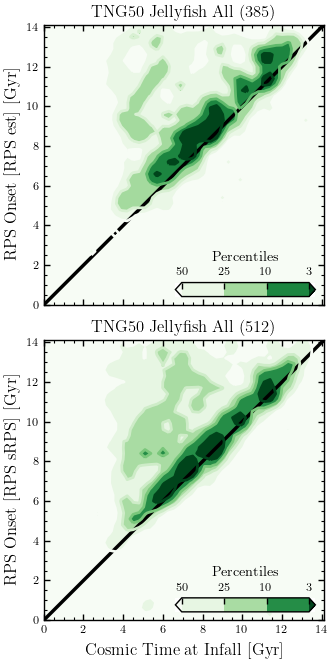

In [14]:
Sim = TNG50_dict[jel_key][tot_key]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(figsizewidth_column, figsizewidth_column * 2.0))

tau0_RPS_tot_label_alt = 'Cosmic Time at Infall [Gyr]'

x_key = tau0_RPS_tot_key
x_label = tau0_RPS_tot_label_alt

tau0_RPS_est_label_alt = 'RPS Onset [RPS est] [Gyr]'
tau0_RPS_sRPS_label_alt = 'RPS Onset [RPS sRPS] [Gyr]'

# fist axis: RPS est
ax = axs[0]
y_key = tau0_RPS_est_key
y_label = tau0_RPS_est_label_alt

ax = plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                          loc='lower right')
ax.set_ylabel(y_label)
ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
ax.set_box_aspect(1)

# second axis: RPS sRPS
ax = axs[1]
y_key = tau0_RPS_sRPS_key
y_label = tau0_RPS_sRPS_label_alt
ax = plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                          loc='lower right')
ax.set_xlabel(x_label, **axislabel_kwargs)
ax.set_ylabel(y_label, **axislabel_kwargs)
ax.plot(ax.get_xlim(), ax.get_ylim(), **one_one_kwargs)
ax.set_box_aspect(1)

fname = '%s_tau0_comparison_contours.pdf'%Sim.save_label
fig.savefig(direc_PP + fname, bbox_inches='tight')


In [15]:
def plot_time_distributions(Sims,
                            x_keys=[tau0_key, tau100_key, tstrip_key],
                            x_labels=[tau0_label_alt, tau100_label_alt, tstrip_label],
                            savefig=False, legend=True):
    """
    Plot 1d histogram distributions for the given x quantities
    Default is tau0, tau100, tauRPS for the standard definition.
    """
    
    if len(x_keys) != len(x_labels):
        raise ValueError('Wrong number of x_keys or x_labels.')
    
    fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
        
    if 'Tstrip' in x_keys[0]:
        x_text = 0.95
        ha = 'right'
        save_key = 'tstrip'
    elif 'T' in x_keys[0]:
        x_text = 0.05
        ha = 'left'
        save_key = 'taus'
        
    axs, _ = plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                               y_step=0.10, x_text=x_text, ha=ha, plot_mask=False)
        
    axs[0] = add_redshift_sincez2(axs[0])
    axs[1] = add_redshift_sincez2(axs[1])
    
    ### add some extra info and text
    # axs[0]: clarify tau0 == infall time
    text = r'$\tau_0 \equiv$ infall time'
    textkwargs = dict(ha='left', va='top', transform=axs[0].transAxes, **text_kwargs)
    text = axs[0].text(0.05, 0.85, text, **textkwargs)
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=axs[1].transAxes, **text_kwargs)
    xval = 0.05
    yval = 0.95
    ystep = 0.11
    ymstar = yval - ystep
    ym200c = ymstar - ystep * 3
    for i, Sim in enumerate(Sims):
        if i == 0:
            axs[1].text(xval, yval, r'at $z=0:$', **textkwargs)
            axs[1].text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            axs[1].text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        axs[1].text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        axs[1].text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if legend:
        legend_handels = add_histlegend_gasz0(Sims)
        fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.15), loc='lower center', bbox_transform=axs[1].transAxes,
                   title=Sims[0].sim_label + ' ' + Sims[0].taudict_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_tau_distributions.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, axs

def add_histlegend_gasz0(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        tau_dict = Sim.tau_dict
        Nobjects = np.where(tau_dict[tau0_key] != -1)[0].size
        label = Sim.gasz0_label + ' (%d)'%Nobjects
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


<IPython.core.display.Javascript object>


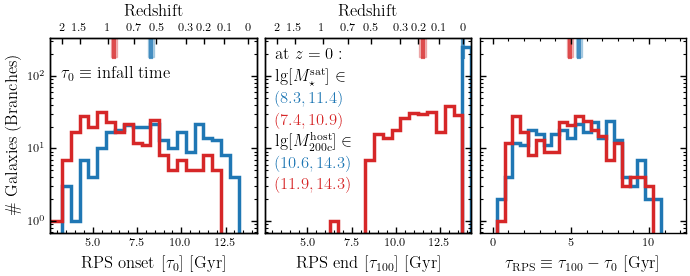

CosmicTime_tau_RPS_tot0 1.3100631690576847e-14 Anderson_ksampResult(statistic=56.92346493959764, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
CosmicTime_tau_RPS_tot100 2.220446049250313e-16 Anderson_ksampResult(statistic=469.4557396783509, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Tstrip_tau_RPS_tot_tau0-tau100 0.00569183966509923 Anderson_ksampResult(statistic=7.0707102146513945, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)


/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)
/tmp/ipykernel_51045/1257131706.py:120: UserWarning: p-value floored: true value smaller than 0.001
  anderson = anderson_ksamp(dsets)


"\nSims = [TNG50_dict[jel_key][nogas_key],\n        TNG50_dict[non_key][nogas_key]]\nfor Sim in Sims:\n    print(Sim.tau_dict['SubfindID'].size)\n    if Sim == Sims[-1]:\n        N = np.where(Sim.tau_dict[Mstarz0_key] > 10.**(10.5))[0].size\n        print(N)\n\nfig, axs = plot_time_distributions(Sims, savefig=savefig)\n"

In [16]:
Sims = [TNG50_dict[jel_key][gas_key],
        TNG50_dict[jel_key][nogas_key]]

fig, axs = plot_time_distributions(Sims, savefig=savefig)

"""
Sims = [TNG50_dict[jel_key][nogas_key],
        TNG50_dict[non_key][nogas_key]]
for Sim in Sims:
    print(Sim.tau_dict['SubfindID'].size)
    if Sim == Sims[-1]:
        N = np.where(Sim.tau_dict[Mstarz0_key] > 10.**(10.5))[0].size
        print(N)

fig, axs = plot_time_distributions(Sims, savefig=savefig)
"""

<IPython.core.display.Javascript object>


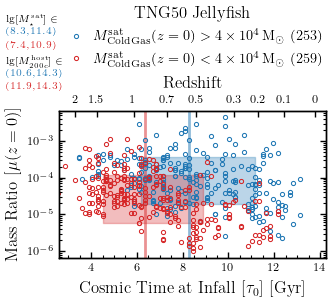

0 0
x16, 50, 84, err: 6.2 8.3 11 0.18
y16, 50, 84, err: 1.95e-05 9.29e-05 3.70e-04 3.9e-05
8 0
x16, 50, 84, err: 4.5 6.4 8.9 0.17
y16, 50, 84, err: 5.96e-06 2.66e-05 1.17e-04 1.2e-05


<IPython.core.display.Javascript object>


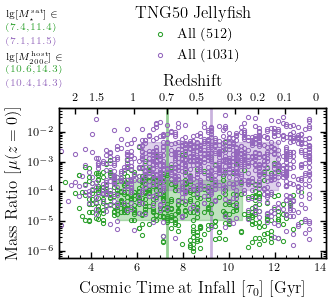

8 0
x16, 50, 84, err: 5.1 7.3 11 0.13
y16, 50, 84, err: 1.06e-05 5.29e-05 2.39e-04 2.1e-05
59 0
x16, 50, 84, err: 6.2 9.2 12 0.1
y16, 50, 84, err: 1.09e-04 8.21e-04 4.57e-03 0.00016


In [17]:
def plot_muz0_infalltimes(Sims, savefig=False):
    """
    Plots muz0 vs infall time [tau_0] for each Sim in Sims
    Sims should be a list of Sim classes. 
    Optionally saves the figure.
    Returns fig, ax
    """

    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = muz0_label_words

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_yscale('log')
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [16, 50, 84]

    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = tau_dict[y_key]
        
        print(len(x[x <= 0]), len(y[y <= 0]))
        
        mask = (x > 0) & (y > 0)

        x_plot = x[mask]
        y_plot = y[mask]

        ax.plot(x_plot, y_plot, label=(Sim.gasz0_label + ' (%d)'%x_plot.size), **Sim.plotkwargs)
        x_16 = np.percentile(x_plot, 16)
        x_84 = np.percentile(x_plot, 84)
        y_16 = np.percentile(y_plot, 16)
        y_84 = np.percentile(y_plot, 84)
        ax.fill_between([x_16, x_84], y_16, y_84, color=Sim.plotkwargs['color'], alpha=0.3)
        x_50 = np.median(x_plot)
        x_err = 1.253 * np.std(x_plot) / np.sqrt(len(x_plot))
        y_50 = np.median(y_plot)
        y_err = 1.253 * np.std(y_plot) / np.sqrt(len(y_plot))
        ax.axvline(x_50, color=Sim.plotkwargs['color'], **median_kwargs)
        print('x16, 50, 84, err: %.2g %.2g %.2g %.2g'%(x_16, x_50, x_84, x_err))
        print('y16, 50, 84, err: %.2e %.2e %.2e %.2g'%(y_16, y_50, y_84, y_err))
        """
        for percentile in percentiles:
            val = np.percentile(x_plot, percentile)
            if percentile == 50:
                kwargs = median_kwargs
            else:
                kwargs = vline_kwargs
            ax.axvline(val, color=Sim.plotkwargs['color'], **kwargs)
        """

    leg_kwargs = dict(ncol=1, bbox_to_anchor=(0.5, 1.25), loc='lower center', bbox_transform=ax.transAxes,
                      title=Sims[0].sim_label + ' ' + jel_label , title_fontsize='medium', fontsize='small')

    ax.legend(**leg_kwargs)   
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=ax.transAxes, fontsize='xx-small', **text_kwargs)
    xval = -0.2
    yval = 1.65
    ystep = 0.09
    ymstar = yval
    ym200c = ymstar - ystep * 3.1
    for i, Sim in enumerate(Sims):
        if i == 0:
            #ax.text(xval, yval, r'at $z=0:$', **textkwargs)
            ax.text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            ax.text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        ax.text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        ax.text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

Sims = [TNG50_dict[jel_key][gas_key],
        TNG50_dict[jel_key][nogas_key]]

fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)

Sims = [TNG50_dict[jel_key][tot_key],
        TNG50_dict[non_key][tot_key]]
fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)


In [18]:
### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=False,
                               double_bin=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_{\rm RPS}$ calculated via'
            labels = [r'RPS sRPS',
                      r'RPS tot']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_label in title:
            title = r'Infall Time [Gyr] $\in$'
        elif fgas_infall_label in title:
            title = r'$\lg[f_{\rm ColdGas}(\tau_0)] \in$'
        elif SCGM_infall_label in title:
            title = r'$\lg[M_{\rm ColdGas}^{\rm sat}(\tau_0)] \in$'
        elif Napopass_tau100_label in title:
            title = r'$N_{\rm orbits}(\tau_{100}) \in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_key
    bin_key = M200cz0_key
    x_label = tstrip_label_long
    
    x_vals   = Sim.tau_dict[x_key]
    bin_vals = np.log10(Sim.tau_dict[bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, ax1, x_key, bin_key, add_legend=True)
    ax1.set_xlabel(x_label, fontsize='large')
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    bin_label = r'$\lg[M_{\rm 200c}^{\rm host}(z=0)]$'
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1])
    
    y0_text = 0.575
    ystep = -0.1
    y1_text = y0_text + ystep
    x0_text = 0.95
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(x0_text, y0_text, r'%s'%bin_label, **textkwargs)
    ax3.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # for the left and right columns, use a double bin?
    if double_bin:
        mstar_bins = Sim.tstrip_histbins_dict[x_key][Mstarz0_key]['bins'] 
        mstar_vals = np.log10(Sim.tau_dict[Mstarz0_key])
        extra_bins_plot = mstar_bins[:2]
        extra_bin_indices = ((mstar_vals >= extra_bins_plot[0]) & (mstar_vals < extra_bins_plot[1])) & bin_indices
        bin_indices = extra_bin_indices
        extra_bin_label = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0], sharey=ax3)
    
    bin_key = SCGM_infall_key
    
    ax2 = plot_binnedhist_panel(Sim, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(x0_text, y0_text, r'%s '%bin_label, **textkwargs)
    ax2.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    if double_bin:
        ax2.text(x0_text, y1_text + ystep, r'%s '%extra_bin_label, **textkwargs)
        ax2.text(x0_text, y1_text + 2*ystep, r'$\in [%.1f, %.1f)$'%(extra_bins_plot[0], extra_bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = Napopass_tau100_key
    
    ax4 = plot_binnedhist_panel(Sim, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(x0_text, y0_text, r'%s'%bin_label, **textkwargs)
    ax4.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    if double_bin:
        ax4.text(x0_text, y1_text + ystep, r'%s '%extra_bin_label, **textkwargs)
        ax4.text(x0_text, y1_text + 2*ystep, r'$\in [%.1f, %.1f)$'%(extra_bins_plot[0], extra_bins_plot[1]), **textkwargs)

    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s'%Sim.plot_label)
    
    if (savefig):
        bin_key = M200cz0_key
        fname = '%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.save_label,
                                                     tstrip_key,
                                                     bin_key,
                                                     bins_plot[0],
                                                     bins_plot[1])
        if double_bin:
            fname = '%s_%s_multipanel_%s_%.1f-%.1f_mstarz0_bin.pdf'%(Sim.save_label,
                                                        tstrip_key,
                                                        bin_key,
                                                        bins_plot[0],
                                                        bins_plot[1])
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig


def plot_binnedhist_panel(Sim, ax, x_key, bin_key, 
                          preset_indices=None, use_preset_bins=True, add_legend=False):
    """
    fill an ax with histograms of tstrip (x_key), binned by some other parameter bin_key.
    Note that x_key should be one of the t_strip keys.
    preset_indices slices x before binning by bin_key.
    use_preset_bins uses the bins defined in Sim.tstrip_histbins_dict[x_key][bin_key]['bins'].
    If False, then uses [0, 33, 67, 100] percentiles. 
    Optionally add the legend as well.
    Returns the ax.
    """
    
    x_vals   = Sim.tau_dict[x_key][preset_indices]
    bin_vals = Sim.tau_dict[bin_key][preset_indices]
    indices  = ((x_vals >= 0) & (bin_vals >= 0))
    x_vals   = x_vals[indices]
    
    bin_label = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    # linear or log binning for bin_vals? 
    if ('T' in bin_key) or (Napopass_tau100_key in bin_key):
        bin_vals = bin_vals[indices]
        legend_title = r'%s $\in$'%bin_label
    elif ('M' in bin_key) or ('GasFraction' in bin_key):
        bin_vals = np.log10(bin_vals[indices])
        legend_title = r'$\log_{10}\big[$%s$\big] \in$'%bin_label
    else:
        print('bin_key %s not supported. returning'%bin_key)
        return
    # assuming linear binning for t_strip spanning all time 
    x_binwidth         = 0.5 # set manually for now 
    x_bins, x_bincents = ru.returnbins([0.01, 13.99], x_binwidth)       

    if (use_preset_bins):
        bins = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    else:
        bins = np.percentile(bin_vals, [0, 33, 67, 100])
        bins[0]  *= 0.99
        bins[-1] *= 1.01 
    bin_indices = np.digitize(bin_vals, bins)
    
    histkwargs_list = Sim.tstrip_histbins_dict[x_key][bin_key]['histkwargs_list']
    
    for bin_i in range(len(bins)-1):

        histkwargs = histkwargs_list[bin_i]
                        
        plot_indices = bin_indices == (bin_i + 1)
        
        x_plot = x_vals[plot_indices]
        Nbin   = len(x_plot)
        
        # if there are no data, then ignore and continue 
        if Nbin == 0:
            continue
        
        labeltext = r'$[%.1f, %.1f)\ (%d)$'%(bins[bin_i],
                                             bins[bin_i+1], Nbin)    
    

        ax.hist(x_plot, x_bins, label=labeltext, **histkwargs)
        
        ax = add_med_ticks(ax, x_plot, color=histkwargs['color'], yval=0.90, errs=True, spread=False)
                
        # add  a vertical line at median
        #ax.axvline(np.median(x_plot), color=histkwargs['color'], **median_kwargs)
    # finish loop over bins
    
    if (add_legend):
        ax.legend(title=legend_title, **legend_kwargs)
        
    return ax


<IPython.core.display.Javascript object>


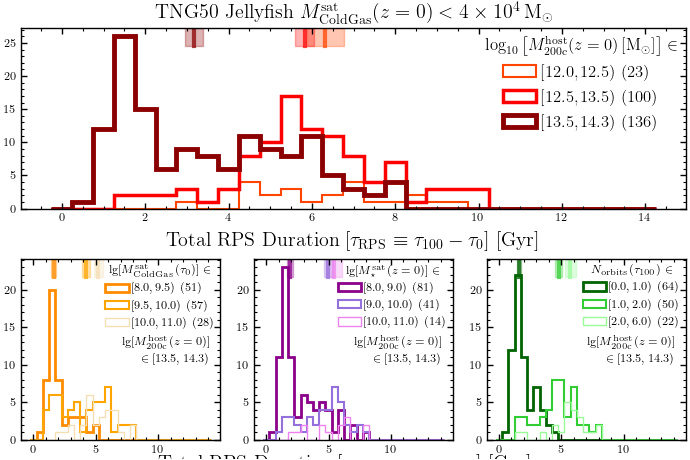

<IPython.core.display.Javascript object>


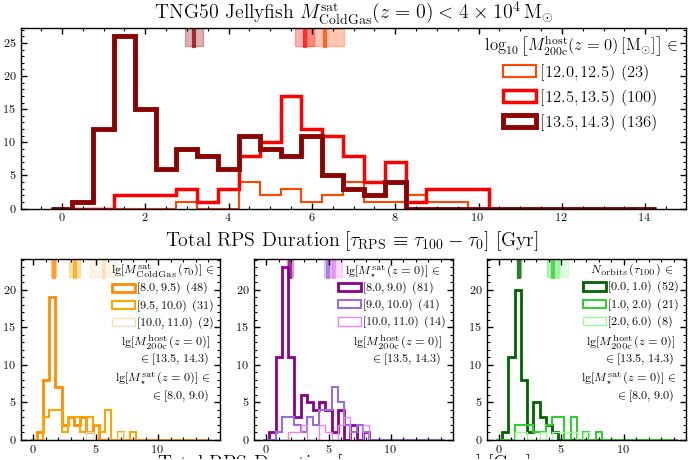

In [19]:
Sim = TNG50_dict[jel_key][nogas_key]
fig = plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=savefig, double_bin=False)
fig = plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=savefig, double_bin=True)

In [20]:
# load input file into a dictionary
def load_grpdict(sim, key, centrals=False):
    # key == 'jellyfish', 'nonjellyf' or 'inspected'; otherwise returns KeyError
    result = {}
    infname = 'zooniverse_%s_%s_clean.hdf5'%(sim, key)
    if centrals:
        infname = 'central_subfind_TNG50-1_branches.hdf5'
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

In [21]:
sim = 'TNG50-1'
grp_dict = load_grpdict(sim, ins_key)
grp_dict_keys = np.array(list(grp_dict.keys()))

tau_dict = TNG50_dict[ins_key][tot_key].tau_dict

In [22]:
Time_key = 'CosmicTime'
SCGM_key = 'SubhaloColdGasMass'
RPS_key = 'SubhaloColdGasTracer_StripTot'
SFR_key = 'SubhaloSFR'
HCDn_key = 'HostCentricDistance_norm'
HCDp_key = 'HostCentricDistance_phys'
RPS_int_tot_key = 'RPS_int_tot'
sRPS_key = 'sRPS'
sSFR_key = 'sSFR'

Time_label = 'Cosmic Time [Gyr]'
SCGM_label = r'$M_{\rm ColdGas}^{\rm subhalo}\, [{\rm M_\odot}]$'
SCGM_label_alt = r'$M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm M_\odot}]$'
RPS_label = r'RPS + Outflows' '\n' r'$[{\rm M_\odot\, yr^{-1}}]$'
sRPS_label = r'RPS+O / $M_{\rm ColdGas}^{\rm subhalo}$' '\n' r'$[{\rm yr^{-1}}]$'
HCDn_label = r'Distance to $z=0$ Host [$R_{\rm 200c}(t)$]'
HCDp_label = r'Distance to $z=0$ Host [pkpc]'

flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
labels = ['Central', 'PreProcessed', r'In $z=0$ Host']
markers = ['^', 's', 'o']

tau_RPS_tot_key = 'tau_RPS_tot'
tau_RPS_est_key = 'tau_RPS_est'
tau_RPS_sRPS_key = 'tau_RPS_sRPS'
tau_medpeak_key = 'tau_medpeak'
quench_key = 'quench'

cmap = cm.get_cmap('YlOrRd')

thin_gray_line_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)
sc_kwargs = dict(cmap=cmap, s=6**2, vmin=-0.1, vmax=3.0)
jelly_kwargs = dict(marker='.', c='k', ms=2, mew=1, fillstyle='none', zorder=2.3)
tau_kwargs = dict(c='k', lw=2, ls='-', marker='None', zorder=3)
dist_plot_kwargs = dict(c='tab:gray', ls='-', marker='None', lw=1, zorder=0.1)

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)
axislabel_kwargs = dict()

tau_keys = [tau_RPS_tot_key,
            tau_RPS_est_key,
            tau_RPS_sRPS_key,
            quench_key]

tau_labels = ['RPS tot (fiducial)',
              'RPS est',
              'RPS sRPS',
              'Quenched']

tauvals_dict = {}
tauvals_dict[tau_RPS_tot_key] = np.array([0, 100])
tauvals_dict[tau_RPS_est_key] = np.array([0])
tauvals_dict[tau_RPS_sRPS_key] = np.array([0])
tauvals_dict[quench_key] = ['']

tau_labels_dict = {}
tau_labels_dict[tau_RPS_tot_key] = ['infall', r'$\tau_{100}$']
tau_labels_dict[tau_RPS_est_key] = ['']
tau_labels_dict[tau_RPS_sRPS_key] = ['']
tau_labels_dict[quench_key] = ['quench']

tau_kwargs = dict(ls='-', marker='None', zorder=3)
tau_kwargs_dict = {}
tau_kwargs_dict[tau_RPS_tot_key] = dict(**tau_kwargs, lw=4.5, c='black')
tau_kwargs_dict[tau_RPS_est_key] = dict(**tau_kwargs, lw=3, c='tab:purple')
tau_kwargs_dict[tau_RPS_sRPS_key] = dict(**tau_kwargs, lw=1.5, c='tab:olive')
tau_kwargs_dict[quench_key] = dict(**tau_kwargs, lw=1, c='tab:red')

tau_text_kwargs = dict(ha='right', va='top', rotation=90, fontsize='medium', zorder=3)

def plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict,
                                savefig=False, clf=False):
    """
    Meant only for branches that have tau_0 at z <= 2 and reach tau_100
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']
    
    fig, ax = plt.subplots()
        
    x_key = Time_key
    y_key = SCGM_key
    c_key = HCDn_key
    dist_key = HCDp_key
    
    ylolim = 1.1e4
    yhilim = 3.9e11

    ax.set_yscale('log')
    ax.set_ylabel(SCGM_label, **axislabel_kwargs)
    ax.set_xlabel(Time_label, **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)

    # add second x axis for redshift
    ax = add_redshift_sincez2(ax, label=True)
        
    # load data for the group
    group = grp_dict[grp_key]
    SnapNum = group['SnapNum']
    x = group[x_key]
    y = group[y_key]
    # replace y values below the ylim with the ylim
    y[y < ylolim] = ylolim
    c = group[c_key]
    
    # add a second y axis for the distance to the host
    dist_ax = ax.twinx()
    dist_c = dist_plot_kwargs['c']
    dist_ylolim = 9.0e0
    dist_yhilim = 9.9e3
    dist_ax.set_ylim(dist_ylolim, dist_yhilim)
    dist_ax.set_yscale('log')
    dist_ax.spines['right'].set_color(dist_c)
    dist_ax.tick_params(axis='y', which='both', color=dist_c, labelcolor=dist_c)
    dist_ax.set_ylabel(HCDp_label, color=dist_c)
    dist_y = group[dist_key]
    dist_ax.plot(x, dist_y, **dist_plot_kwargs)
    
    # add markers where there are pericenter passages
    peri_indices = np.where((group['Nperipass'][:-1] - group['Nperipass'][1:]) == 1)[0]
    dist_ax.plot(x[peri_indices], dist_y[peri_indices], marker='+', color='black')
    apo_indices = np.where((group['Napopass'][:-1] - group['Napopass'][1:]) == 1)[0]
    dist_ax.plot(x[apo_indices], dist_y[apo_indices], marker='x', color='black')

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'Satellite']
    markers = ['^', 's', 'o']
            
    done_indices  = group['ins_flags'] == 1
    
    # plot data for the different flags
    ax, sc = add_grp_dset(ax, group, y_key, ylolim=ylolim)
    cbar = fig.colorbar(sc, ax=ax, extend='max')
    cbar.set_label(HCDn_label, **axislabel_kwargs)    
    
    # add tau markers
    tau_keys = [tau_RPS_tot_key, quench_key]
    yval = 0.85
    for tau_i, tau_key in enumerate(tau_keys):
        ax = add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                            yval=yval, tau_labels_dict=tau_labels_dict)
        
    # add extra important info at infall, tau0, z0  
    M200c_host_z0 = tau_dict[M200cz0_key][taudict_index][0]
    SubhaloMstar_z0 = tau_dict[Mstarz0_key][taudict_index][0]
    tau0 = tau_dict[tau0_RPS_tot_key][taudict_index]
    tau100 = tau_dict[tau100_RPS_tot_key][taudict_index]
    tauRPS = tau_dict[tstrip_RPS_tot_key][taudict_index]
        
    text_kwargs = dict(ha='right', va='bottom', fontsize='large', transform=ax.transAxes, zorder=3)
    
    text = (r'\begin{align*}' +
            r'\tau_0 \equiv \text{infall} = %.1f\, [{\rm Gyr}] & \\'%(tau0) + 
            r'\tau_{100} := M_{\rm ColdGas}^{\rm subhalo} = 0: %.1f\, [{\rm Gyr}] & \\'%(tau100) + 
            r'\tau_{\rm RPS} \equiv \tau_{100} - \tau_{0} = %.1f\, [{\rm Gyr}] &'%(tauRPS) + 
            r'\end{align*}')
    
    text = ax.text(0.999, 0.01, text, **text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add legend
    snap = SnapNum[0]
    subfindID = int(grp_key)
    title = (r'TNG50 $z=0$' + '\n subfindID %d \n'%(subfindID) + 
             r'$M_{\star}^{\rm sat} = %s\, [{\rm M_\odot}]$'%(ru.latex_float(SubhaloMstar_z0, 2)) + '\n' +
             r'$M_{\rm 200c}^{\rm Host} = %s\, [{\rm M_\odot}]$'%(ru.latex_float(M200c_host_z0, 2)))
    ax.legend(loc=(0.025, 0.05), title=title)
               
    # ensure that the distance axis is behind the primary axis and that we can still see both axes
    ax.set_zorder(dist_ax.get_zorder()+1)
    ax.set_frame_on(False)
    
    if savefig: 
        outdirec = '../Figures/Tracers/TNG50-1/SCGM_Evolution/'
        fname = '%s_snap-099_subfindID-%s_SCGM-evolution.pdf'%(sim, grp_key)
        #fig.savefig(outdirec + fname, bbox_inches='tight')
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    if clf:
        plt.close(fig)
        return
    
    return fig, ax


def plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict,
                                          savefig=False, clf=False):
    """
    Plot multiple panels of the subhalo cold gas mass evolution with tracer particles.
    """
    group = grp_dict[grp_key]
    taudict_index = int(grp_key) == tau_dict['SubfindID']

    # start figure -- add labels and limits
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7,6))

    x_key = Time_key
    x_label = Time_label
    axs[-1].set_xlabel(x_label, **axislabel_kwargs)

    # add second x axis for redshift
    for ax in axs:
        if ax == axs[0]:
            label = True
        else:
            label = False
        add_redshift_sincez2(ax, label=label)
        
    # add tau markers
    y0 = 0.80
    ystep = 0.025
    for tau_i, tau_key in enumerate(tau_keys):
        if tau_key == quench_key:
            continue
        if tau_i < 3:
            yval = y0 + ystep * tau_i
        else:
            yval = 0.85
        for ax in axs:
            if ax == axs[0]:
                _ = add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                                  yval=yval, tau_labels_dict=tau_labels_dict)
            else:
                _ = add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                                  yval=yval)
        
    # begin plotting
    subhalo_indices = group['SubfindID'] != -1
    x = group[x_key][subhalo_indices]

    # begin axis 0: SCGM vs time; integral of RPS + outflows vs time
    ylolim = 7.0e6
    yhilim = 3.9e11

    ax = axs[0]
    
    ax.set_yscale('log')
    ax.set_ylabel(SCGM_label_alt, **axislabel_kwargs)
    ax.set_ylim(ylolim, yhilim)

    ax, sc = add_grp_dset(ax, group, SCGM_key, ylolim=ylolim)
    
    # add colorbar
    cbar = fig.colorbar(sc, ax=axs, extend='max')
    cbar.set_label(HCDn_label, **axislabel_kwargs)

    # add legend
    ax.legend(loc='lower left', ncol=2, title='%s snap %d subfindID %d'%(sim, 99, int(grp_key)))
    
    # label the various tau markers
    y0 = 0.7
    x0 = 0.975
    ystep = -0.15
    text_kwargs = dict(ha='right', va='top', fontsize='medium', transform=ax.transAxes, zorder=3)
    for i, tau_key in enumerate(tau_keys):
        if tau_key == quench_key:
            continue
        y = y0 + i * ystep
        c = tau_kwargs_dict[tau_key]['c']
        text = tau_labels[i]
        text = ax.text(x0, y, text, c=c, **text_kwargs)

    # begin axis 1: RPS + outflows vs time
    ax = axs[1]
    yhilim = 3.0e2
    ylolim = 9.0e-3
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(RPS_label, **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, RPS_key, ylolim=ylolim)

    # add the line for SFR
    SFR = group[SFR_key][subhalo_indices]
    ax.plot(x, SFR, **thin_gray_line_kwargs)
    
    annotate_index = np.argmin(abs(x - 4.5))
    annotate_kwargs = dict(xytext=((1.0-x0),(0.05)), textcoords='axes fraction',
                           arrowprops=dict(facecolor=thin_gray_line_kwargs['c'], shrink=0.05),
                           fontsize='medium', ha='left', va='bottom', c=thin_gray_line_kwargs['c'])
    ax.annotate('SFR', (x[annotate_index], SFR[annotate_index]), **annotate_kwargs)

    # begin axis 2: RPS + outflows / MColdGas vs time
    ax = axs[2]
    yhilim = 9.0e-8
    ylolim = 1.1e-12
    tH_inv = 7.246e-11
    ax.set_yscale('log')
    ax.set_ylim(ylolim, yhilim)
    ax.set_ylabel(sRPS_label, **axislabel_kwargs)
    ax, _ = add_grp_dset(ax, group, sRPS_key, ylolim=ylolim)

    # add the line for sSFR
    sSFR = group[sSFR_key][subhalo_indices]
    ax.plot(x, sSFR, **thin_gray_line_kwargs)
    
    ax.annotate(r'SFR / $M_{\rm ColdGas}^{\rm subhalo}$', (x[annotate_index], sSFR[annotate_index]), **annotate_kwargs)

    # add a line at tH_inv
    guideline_text_kwargs = dict(fontsize='small', zorder=3)
    ax.plot(ax.get_xlim(), [tH_inv, tH_inv], ls='--', marker='None', c='black', lw=1.5)
    text = ax.text(ax.get_xlim()[1] - 0.2, tH_inv*1.5, r'$1 / t_{\rm H} \sim 7\times10^{-11}\, {\rm yr^{-1}}$',
                   ha='right', va='bottom', **guideline_text_kwargs)
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])
    
    # add a line at 1 / 150 Myr ~ 1 / (time between snapshots)
    snap_inv = 1./(150e6)
    ax.plot(ax.get_xlim(), [snap_inv, snap_inv], ls=':', marker='None', c='black', lw=1.5)
    text = ax.text(ax.get_xlim()[0] + 0.2, snap_inv*1.5, r'$1/\Delta t_{\rm snap} \approx 1 / 150\, {\rm Myr}$',
                   ha='left', va='bottom', **guideline_text_kwargs)    
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=1.5),
                           pe.Normal()])    
    
    if savefig: 
        outdirec = '../Figures/Tracers/TNG50-1/TracerEvoltuion_3panel/'
        fname = '%s_snap-099_subfindID-%s_SCGM-tracer-evolution_multipanel.pdf'%(sim, grp_key)
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    if clf:
        plt.close(fig)
        return
    
    return fig, axs


def plot_SCGM_tracer_evolution(grp_key, grp_dict, tau_dict,
                               savefig=False, clf=False):
    
    taudict_index = int(grp_key) == tau_dict['SubfindID']
    
    plot_kwargs = dict(marker='None')
    tauvals_dict = {}
    tauvals_dict[tau_RPS_tot_key] = np.array([0])
    
    # start figure -- add labels and limits
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(figsizewidth, figsizewidth/1.5))
    
    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.0))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(zs)], 0.1)
    axs[0].set_xlim(xlolim, xhilim)
    axs[-1].set_xlabel(r'Cosmic Time [Gyr]', **axislabel_kwargs)
    
    # add second x axis for redshift
    for ax in axs:
        if ax == axs[0]:
            label = True
        else:
            label = False
        add_redshift_sincez2(ax, label=label)
    
    # top axis: cold gas mass
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$M_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot}]$', **axislabel_kwargs)
    
    y_keys = ['SubhaloColdGasMass',
              'SubhaloColdGasTracer_Mass',
              'SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out']
        
    gas_kwargs = dict(**plot_kwargs, c='black', lw=3, ls='-', alpha=1, label=r'cold gas cells')
    net_kwargs = dict(**plot_kwargs, c='tab:gray', lw=gas_kwargs['lw']-0.5, ls='--', alpha=1, label=r'cold gas tracers')
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=1.0, ls='-', label=r'new tracer mass')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-', label=r'lost tracer mass')
    
    kwargs_list = [gas_kwargs, net_kwargs, new_kwargs, out_kwargs]
    
    group   = grp_dict[grp_key]
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = SubfindID >= 0
    x_key  = 'CosmicTime'
    x = group[x_key][indices]
    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices]
        kwargs = kwargs_list[i]
        
        axs[0].plot(x, y, **kwargs)
        
    axs[0].legend(ncol=1)
    
    ylolim = 1.1e6
    yhilim = 3.9e11
    
    axs[0].set_ylim(ylolim, yhilim)
    
    # add tau markers
    for ax in axs:
        _ = add_tau_ticks(ax, group, tau_RPS_tot_key, tau_dict, taudict_index,
                          yval=0.80, tau_labels_dict=tau_labels_dict)

    # bottom axis: cold gas mass derivatives
    axs[1].set_yscale('log')
    axs[1].set_ylabel(r'$\dot{M}_{\rm ColdGas}^{\rm subhalo}~[{\rm M_\odot\, yr^{-1}}]$', **axislabel_kwargs)     
    
    y_keys = ['SubhaloColdGasTracer_new',
              'SubhaloColdGasTracer_out',
              'SubhaloColdGasTracer_StripTot',
              'SubhaloColdGasTracer_Heat',
              'SubhaloColdGasTracer_Star',
              'SubhaloColdGasTracer_BH']
        
    new_kwargs = dict(**plot_kwargs, c='tab:blue', lw=3.0, ls='-')
    out_kwargs = dict(**plot_kwargs, c='tab:red', lw=new_kwargs['lw'], ls='-')
    strip_kwargs = dict(**plot_kwargs, c='tab:olive', lw=1.0, ls='-', label=r'RPS+Outflows')
    heat_kwargs = dict(**plot_kwargs, c='tab:pink', lw=strip_kwargs['lw'], ls='--', label=r'Heating')
    star_kwargs = dict(**plot_kwargs, c='tab:orange', lw=strip_kwargs['lw'], ls=':', label=r'SF')
    bh_kwargs = dict(**plot_kwargs, c='k', lw=strip_kwargs['lw'], ls='-.', label=r'BH Acc.$\times 100$')
    
    kwargs_list = [new_kwargs, out_kwargs, strip_kwargs, heat_kwargs, star_kwargs, bh_kwargs]
    
    SnapNum = group['SnapNum']
    SubfindID = group['SubfindID']
    indices = (SubfindID >= 0) 
    CosmicTimes = group['CosmicTime'][indices]
    time_diffs = (CosmicTimes[:-1] - CosmicTimes[1:]) * 1.0e9
    time_diffs = np.append(time_diffs, -1.)

    x = group[x_key][indices]

    for i, y_key in enumerate(y_keys):
        y = group[y_key][indices] 
        if y_key == y_keys[-1]:
            y *= 100.
        if i == 0 or i == 1:
            y /= time_diffs
            
        # replace y values below the ylim with the ylim
        #y[y < ylolim] = ylolim
        kwargs = kwargs_list[i]
        
        axs[1].plot(x, y, **kwargs)
        
    yhilim = 3e2
    ylolim = 1.1e-2
    axs[1].set_ylim(ylolim, yhilim)
        
    # mark where RPS + Outflows ~ outflows and where it's ~ RPS
    infall_time = tau_dict[tau0_key][taudict_index]
    vspan_kwargs = dict(color='tab:gray', alpha=0.1)
    ax = axs[1]
    ax.axvspan(ax.get_xlim()[0], infall_time, **vspan_kwargs)
    text_kwargs = dict(ha='right', va='bottom', ma='center', fontsize='small', color='tab:gray')
    text = r'RPS+O $\approx$' + '\n Outflows'
    ax.text(infall_time-0.1, ylolim * 3, text, **text_kwargs)
    annotate_kwargs = dict(xytext=(infall_time-0.1, ylolim * 2),
                           arrowprops=dict(facecolor='tab:gray', shrink=0.05))
    ax.annotate('', (infall_time-1.5, ylolim * 2.0), **annotate_kwargs)
    
    text_kwargs['ha'] = 'left'
    text_kwargs['color'] = 'black'
    text = r'RPS+O $\approx$' + '\n RPS'
    ax.text(infall_time+0.1, ylolim * 3, text, **text_kwargs)
    annotate_kwargs['xytext'] = (infall_time + 0.1, ylolim * 2)    
    ax.annotate('', (infall_time+1.5, ylolim * 2.0), **annotate_kwargs)
    
    axs[1].legend(title='TNG50 subfindID %d'%(SubfindID[0]))
    
    snap = 99
    subfindID = SubfindID[0]
    
    if savefig:
        fname = '%s_snap-%03d_subfindID-%s_SCGM-tracer-evolution.pdf'%(sim, snap, grp_key)    

        direc = '../Figures/Tracers/TNG50-1/TracerEvoltuion_2panel/'

        fig.savefig(direc_PP + fname, bbox_inches='tight')
        
    if clf:
        plt.close(fig)
        return
    
    return fig, axs



def add_grp_dset(ax, group, y_key, x_key=Time_key, c_key=HCDn_key, ylolim=None):
    """
    plot the scatter with different markers depending on FoF membership
    must be called after defining all the kwargs, etc. 
    returns ax, sc (the scatter collection, so one can add a colorbar)
    """

    flag_keys = ['central_flags', 'preprocessed_flags', 'memberlifof_flags']
    labels = ['Central', 'PreProcessed', r'Satellite']
    markers = ['^', 's', 'o']

    # load data for the group
    subhalo_indices = np.where(group['SubfindID'] != -1)[0]
    # if using RPS from tracers, then ignore the earliest datum point
    if 'Tracer' in y_key or 'RPS' in y_key:
        subhalo_indices = subhalo_indices[:-1]
    SnapNum = group['SnapNum'][subhalo_indices]
    x = group[x_key][subhalo_indices]
    y = group[y_key][subhalo_indices]
    c = group[c_key][subhalo_indices]
    
    if ylolim is not None:
        y[y < ylolim] = ylolim
                
    jel_indices = group['jel_flags'][subhalo_indices] == 1
    ax.plot(x[jel_indices], y[jel_indices], **jelly_kwargs)

    ins_indices = group['ins_flags'][subhalo_indices] == 1
    
    xlolim = ax.get_xlim()[0]

    # plot data for the different flags
    for flag_index, flag_key in enumerate(flag_keys):
        marker = markers[flag_index]
        label = labels[flag_index]
        flags = group[flag_key][subhalo_indices]
        plot_indices = flags == 1
        
        # if there are no points to plot, then continue (so it's not in the legend)
        test = x[plot_indices] > xlolim
        if len(test[test]) == 0:
            continue
        
        # add blank points for the legend
        ax.scatter([], [], c='black', marker=marker, **sc_kwargs, label=label)

        # add outlines for the points that were inspected 
        ax.scatter(x[plot_indices & ins_indices], y[plot_indices & ins_indices], c=c[plot_indices & ins_indices],
                   marker=marker, edgecolors='black', zorder=2.1, **sc_kwargs)
        
        # plot the actual data 
        sc = ax.scatter(x[plot_indices & ~ins_indices], y[plot_indices & ~ins_indices],
                        c=c[plot_indices & ~ins_indices], marker=marker, **sc_kwargs) 
        
    return ax, sc


def add_tau_ticks(ax, group, tau_key, tau_dict, taudict_index,
                  yval=0.85, tau_labels_dict=False):
    """
    Add tick marks at the relevant tau values 
    must be called after defining tauvals_dict
    returns axs
    """
    tau_vals = tauvals_dict[tau_key]

    xlolim = ax.get_xlim()[0]
    
    for tau_val_i, tau_val in enumerate(tau_vals):
        key = 'CosmicTime_' + tau_key + str(tau_val)
        xval = tau_dict[key][taudict_index]
        
        if xval > xlolim:
            ax.plot([xval, xval], [yval, 1.0], **tau_kwargs_dict[tau_key],
                    transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
            if tau_labels_dict:
                text = tau_labels_dict[tau_key][tau_val_i]
                ax.text(xval-0.025, 0.98, text, c=tau_kwargs_dict[tau_key]['c'], **tau_text_kwargs,
                        transform=transforms.blended_transform_factory(ax.transData, ax.transAxes))
                                  
    return ax



In [23]:
"""
savefig=False
clf=True
for grp_key in grp_dict_keys:
    plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)
    plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)
    plot_SCGM_tracer_evolution(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)
"""

'\nsavefig=False\nclf=True\nfor grp_key in grp_dict_keys:\n    plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)\n    plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)\n    plot_SCGM_tracer_evolution(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)\n'

<IPython.core.display.Javascript object>


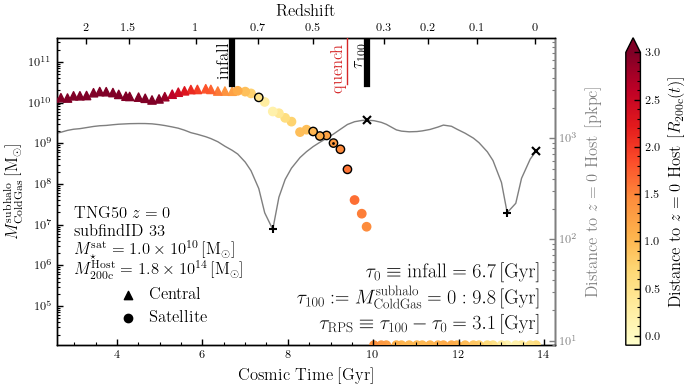

<IPython.core.display.Javascript object>


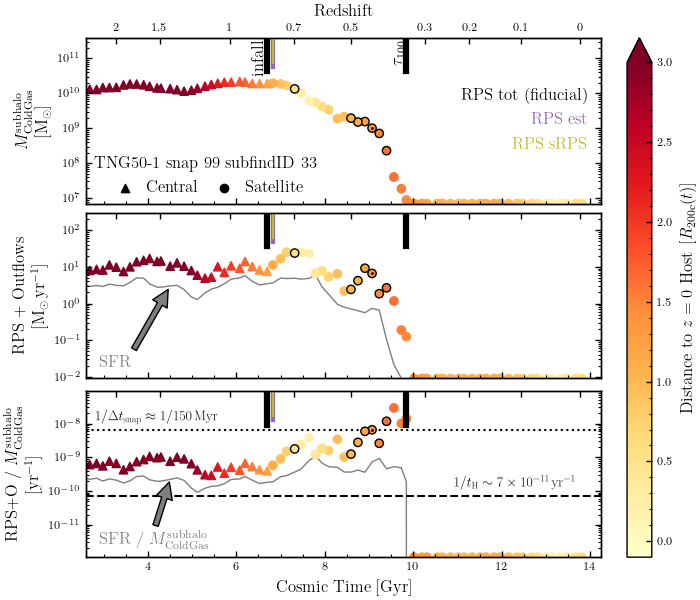

<IPython.core.display.Javascript object>


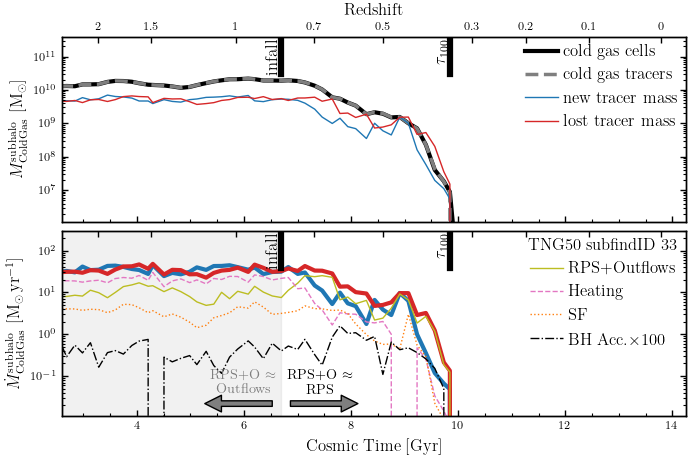

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [24]:
savefig=savefig
clf=False
grp_key = '%08d'%(33)
fig, ax = plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)
fig, axs = plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)
fig, axs = plot_SCGM_tracer_evolution(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)



<IPython.core.display.Javascript object>


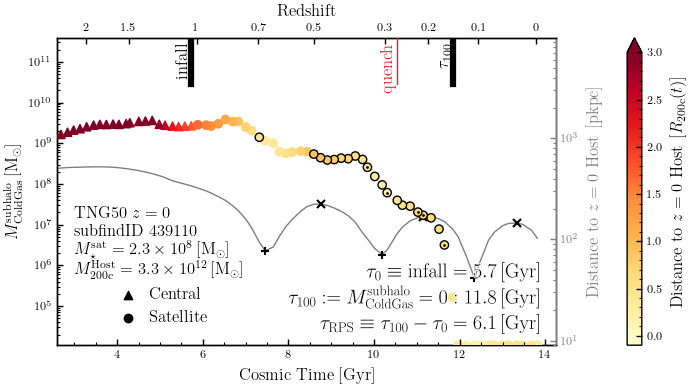

<IPython.core.display.Javascript object>


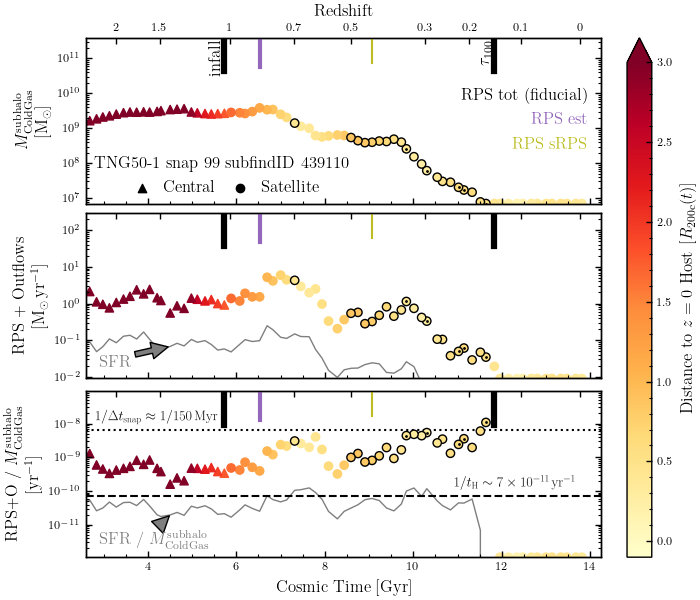

<IPython.core.display.Javascript object>


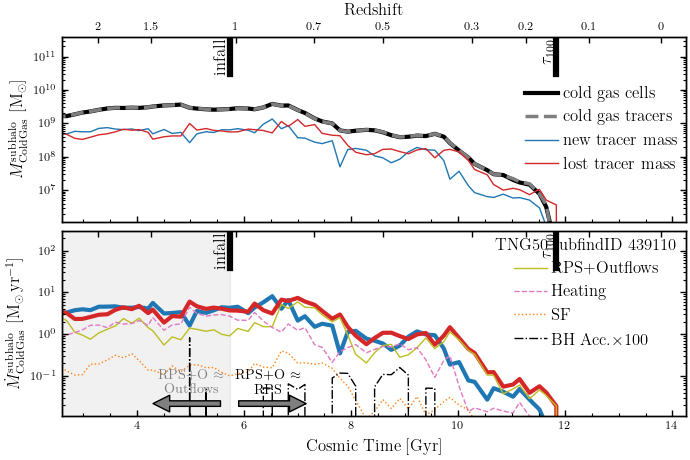

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [25]:
grp_key = '%08d'%(439110)
fig, ax = plot_SCGM_evolution_sincez2(grp_key, grp_dict, tau_dict, savefig=savefig)
fig, axs = plot_SCGM_tracer_evolution_multipanel(grp_key, grp_dict, tau_dict, savefig=savefig)
fig, axs = plot_SCGM_tracer_evolution(grp_key, grp_dict, tau_dict, savefig=savefig, clf=clf)

In [26]:
def load_gasmaps(sim, key='jellyfish'):
        
    result = {}
    fname = 'zooniverse_%s_%s_gasmaps.hdf5'%(sim, key)
    with h5py.File('../Output/zooniverse/' + fname, 'a') as f:
        for group_key in f.keys():
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
            
    return result

sim = 'TNG50-1'
snap = 99
gasmaps = load_gasmaps(sim)
gasmaps_keys = np.array(list(gasmaps.keys()))


In [27]:
map_keys = ['Temperature', 'GFM_Metallicity']

kwargs_imshow = dict(aspect='equal', interpolation='gaussian', origin='lower', alpha=1.0)

cmap_kwargs_dict = {}
cmap_kwargs_dict[map_keys[0]] = dict(cmap='turbo', vmin=3.0, vmax=7.5)
cmap_kwargs_dict[map_keys[1]] = dict(cmap='viridis', vmin=-1.0, vmax=0.2)

cbar_kwargs = dict(orientation='vertical', fraction=0.046, extend='both')

cbar_label_kwargs = dict(fontsize='medium')
cbar_label_dict = dict()
cbar_label_dict[map_keys[0]] = r'Gas Temperature [log K]'
cbar_label_dict[map_keys[1]] = r'Gas Metallicity [log ${\rm Z_\odot}$]'

text_kwargs = dict(color='white')

circ_kwargs = dict(fill=False, color='white', lw=1.0)
legend_kwargs = dict(loc='lower right', labelcolor='white')

def plot_gasmap_multipanel(map_key, savefig=False):
    """
    Create the multiplanel poster of jellyfish gas maps.
    """
    #fig, axs = plt.subplots(5, 4, figsize=(figsizewidth, figsizewidth*(5./4.15)), sharex=False, sharey=False)
    fig, axs = plt.subplots(4, 4, figsize=(figsizewidth, figsizewidth * 1.0))
    
    fig.suptitle(r'TNG50 Example Jellyfish at $z=0$', y=0.90)

    for key_i, gasmaps_key in enumerate(gasmaps_keys):
        ax = axs.flat[key_i]
        jelly = gasmaps[gasmaps_key]
        _, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=False, annotate_flag=True, text_fontsize=4)

    #fig.subplots_adjust(bottom=0.1)
    cax = fig.add_axes([0.15, 0.075, 0.7, 0.025])
    cbar = fig.colorbar(h, cax=cax, orientation='horizontal', extend='both')
    cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)
    cbar.ax.tick_params(labelsize='x-small')

    fig.subplots_adjust(wspace=0, hspace=0)
    
    if savefig:
        fname = '%s_%s_multipanel.pdf'%(sim, map_key)
        
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, axs

def plot_gasmap_singlepanel(jelly, map_key, cbar_flag=False, annotate_flag=False, text_fontsize='large',
                            savefig=False):
    """
    Create and plot a single gas map for a jellyfish.
    """
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax, h = plot_gasmap(ax, jelly, map_key=map_key, cbar_flag=cbar_flag, annotate_flag=annotate_flag,
                        text_fontsize=text_fontsize)
    
    if savefig:
        outdirec = '/Users/rohr/MPCDFDataShare/Rohr_Pillepich/Figures/GasMaps/PosterImages/'
        fname = '%s_snap-%03d_subfindID-%08d_%s'%(sim, jelly['SnapNum'], jelly['SubfindID'], map_key)

        if annotate_flag:
            fname += '_annotated'
            
        plt.savefig(outdirec + fname + '.pdf', bbox_inches='tight')
        
    return fig, ax

def plot_gasmap(ax, jelly, map_key='Temperature', cbar_flag=False, annotate_flag=False,
                text_fontsize=3):
    """
    Plot the gas map onto an existing ax for a given jellyfish.
    """

    # turn off ticks 
    ax.set_xticks([])
    ax.set_yticks([])

    # mask empty pixels with median of the nonempty pixels
    vals          = jelly[map_key + '_map']
    indices       = vals == 0
    replace       = np.median(vals[~indices])
    vals[indices] = replace

    Subhalo_Rgal = jelly['Subhalo_Rgal'][0]
    maxcoord     = 20. * Subhalo_Rgal

    # plot histogram 
    h = ax.imshow(vals, **kwargs_imshow, **(cmap_kwargs_dict[map_key]),
                  extent=[-maxcoord, maxcoord, -maxcoord, maxcoord])

    if cbar_flag:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)
        cbar.set_label(cbar_label_dict[map_key], **cbar_label_kwargs)

    if annotate_flag:
        Group_M_Crit200          = jelly['HostGroup_M_Crit200'][0]
        Subhalo_Mstar_Rgal       = jelly['Subhalo_Mstar_Rgal'][0]
        SubhaloColdGasMass       = jelly['SubhaloColdGasMass'][0]
        HostCentricDistance_norm = jelly['HostCentricDistance_norm'][0]
        HostCentricDistance_phys = jelly['HostCentricDistance_phys'][0]

        SnapNum = jelly['SnapNum'][0]
        Redshift = jelly['Redshift'][0]
        SubhaloGrNr = jelly['SubhaloGrNr'][0]
        subfindID = jelly['SubfindID'][0]

        length = 30. # kpc -- for a constant distance 

        text_kwargs_copy = text_kwargs.copy()
        text_kwargs_copy['transform'] = ax.transAxes
        text_kwargs_copy['fontsize'] = text_fontsize

        text = ax.text(0.025, 0.975, 
                       r'$M_{\rm 200c}^{\rm Host} = %s\, {\rm M_\odot} $'%(ru.latex_float(Group_M_Crit200, 2)) + '\n' +
                       r'$M_{\star}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(Subhalo_Mstar_Rgal, 2)) + '\n' + 
                       r'$M_{\rm ColdGas}^{\rm Sat} = %s\, {\rm M_\odot} $'%(ru.latex_float(SubhaloColdGasMass, 2)) + '\n' +
                       r'$d_{\rm sat}^{\rm host} = %3.2f\, R_{\rm 200c}^{\rm host},\ %d\, {\rm kpc}$'%(HostCentricDistance_norm, HostCentricDistance_phys),
                       ha='left', va='top', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        text = ax.text(0.025, 0.025,
                       'Subfind ID = %d \n'%(subfindID) + 
                       'Host FoF ID = %d \n'%(SubhaloGrNr) +
                       '%s, z = %d'%(sim, Redshift),
                       ha='left', va='bottom', ma='left', **text_kwargs_copy)

        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.75),
        #                       pe.Normal()])

        # add circles at the important radii    
        subrgal = patches.Circle((0.0,0.0), Subhalo_Rgal, linestyle='-', **circ_kwargs,
                                label=r'$R_{\rm gal}^{\star} = %#3.3g\, {\rm kpc}$'%float(Subhalo_Rgal))
        ax.add_patch(subrgal)

        ax.legend(**legend_kwargs, fontsize=text_fontsize)
        
    return ax, h




<IPython.core.display.Javascript object>


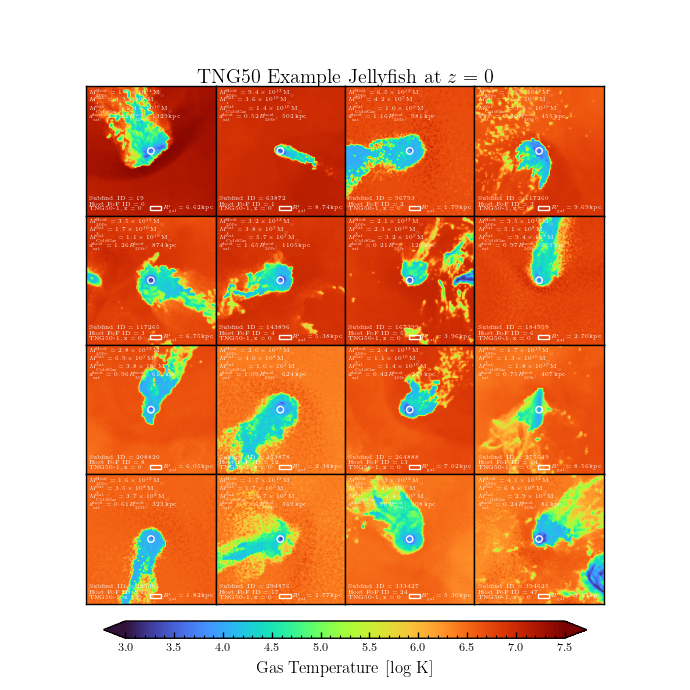

/tmp/ipykernel_51045/2090076553.py:41: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


<IPython.core.display.Javascript object>


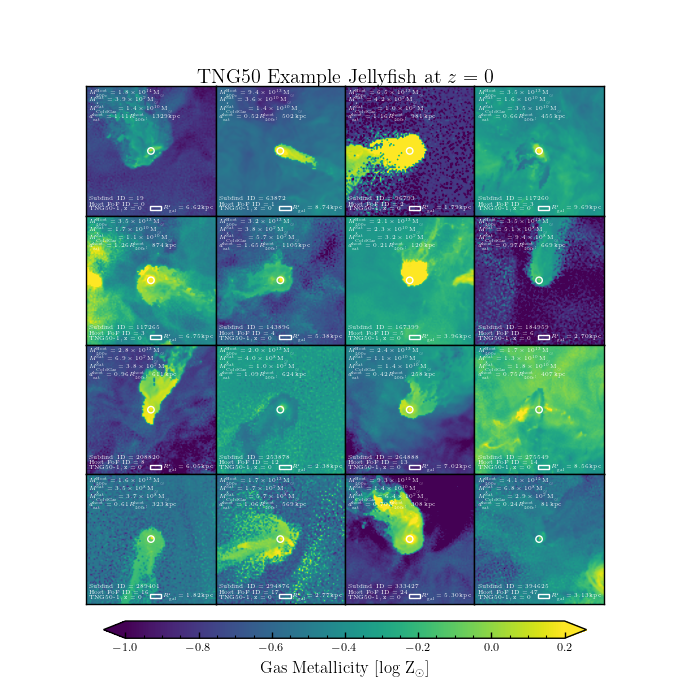

In [28]:
for map_key in map_keys:
    _ = plot_gasmap_multipanel(map_key, savefig=savefig)

In [29]:
x_key = Time_key
x_key_norm = tau0_RPS_tot_key

y_key = HCDn_key 

c_key = RPS_int_tot_key

y_binwidth = 0.20 # [r/r200c]
y_bins = np.arange(-y_binwidth/2.0, 4.0 + y_binwidth/2.0 + y_binwidth*1.0e-3, y_binwidth)
y_bincents = (y_bins[1:] + y_bins[:-1])/2.0
x_binwidth = 0.15 # Gyr
x_max = 7.0 # gyr
x_min = -x_binwidth/2.0 # Gyr
x_bins = np.arange(x_min, x_max + x_binwidth/2.0, x_binwidth)
x_bincents = (x_bins[1:] + x_bins[:-1])/2.0

RPS_frac = 0.5

extent = [x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()]
hist2d_kwargs = dict(origin='lower', cmap='viridis', aspect='auto',
                     norm=mpl.colors.LogNorm(vmin=1.0e-3, vmax=1.5e-1),
                     extent=extent)

fill_between_kwargs = dict(color='tab:gray', alpha=0.2)

cbar_label = r'Fractional RPS Cold Gas Mass Loss $[f_{\rm RPS}]$'
cbar_kwargs = dict(extend='both', label=cbar_label)

Tsinceinfall_label = r'Time Since Infall [Gyr]'
cbar_halo_label = r'Total Cold Gas from RPS [${\rm M_{\odot}}]$'
HCDnz0_label = r'Host-Centric Distance $[R_{\rm 200c}]$'
rhoCGas_label = r'$\rho_{\rm ColdGas}$' + '\n' + r'$[{\rm M_\odot} / {\rm kpc}^3]$'
HCDn_label_alt = 'Host-Centric Distance \n' + r'$[R_{\rm 200c}(t)]$'

percentiles = [50]

radii_key = 'radii'
mass_key = 'mass_shells'
dens_key = 'densities_shells'
R200c_key = 'HostGroup_R_Crit200'

centrals_GRP = load_grpdict(sim, taudict_key, centrals=True)
centrals_keys = np.array(list(centrals_GRP.keys()))


def calc_fracRPSloss(taudict_index, tau_dict, grp_dict, 
                     norm=True, peakRPS=True):
    """
    For a given galaxy in the tau_dict, calculate the 
    fractional RPS loss at each snapshot after infall.
    Give this value in a 2D array of host-centric distance vs
    time since infall.
    """
    
    result = np.zeros([y_bins.size-1, x_bins.size-1], dtype=float)
    if peakRPS:
        result_frac = result.copy()
        min_vals = [-1, -1, -1, -1]
        min_bins = [-1, -1, -1, -1]
        full_result = result, result_frac, min_vals, min_bins
    else:
        full_result = result
    
    subfindID = tau_dict['SubfindID'][taudict_index]
    grp_key = '%08d'%subfindID
    group = grp_dict[grp_key]
    
    subfind_indices = group['SubfindID'] != -1

    x_result = group[x_key][subfind_indices] - tau_dict[x_key_norm][taudict_index]
    indices = x_result >= 0
    infall_index = np.where(x_result == 0)[0]
        
    if infall_index.size != 1:
        print('grp_key %s has no infall index'%(grp_key))
        return full_result
    
    infall_index = infall_index[0]
    x = x_result[indices]

    c = group[c_key][subfind_indices][indices] - group[c_key][subfind_indices][1:infall_index+2]
    if norm:
        c_norm = c.sum()
        if c_norm == 0:
            print('grp_key %s has c_norm = 0'%(grp_key))
            return full_result 
        weights = c / c_norm
    else:
        weights = c
        
    y = group[y_key][subfind_indices][:infall_index+1]
    
    result[:,:] = np.histogram2d(y, x, bins=[y_bins, x_bins], weights=weights)[0]
    
    if not peakRPS:
        return result
    else:
        vals = weights[::-1]
        x_calc = x[::-1]
        y_calc = y[::-1]

        min_length = x_calc.max() - x_calc.min()
        for start_i, start in enumerate(x_calc):
            cumsum = np.cumsum(vals[start_i:])
            where = np.where(cumsum >= RPS_frac)[0]
            if where.size == 0:
                break
            end_i = where.min() + start_i + 1
            end = x_calc[end_i]
            length = x_calc[end_i] - start
            if length < min_length:
                min_length = length
                min_start_i = start_i
                min_end_i = end_i

        x_frac = x_calc[min_start_i:min_end_i]
        y_frac = y_calc[min_start_i:min_end_i]
        vals_frac = vals[min_start_i:min_end_i]

        result_frac[:,:] = np.histogram2d(y_frac, x_frac, bins=[y_bins, x_bins], weights=vals_frac)[0]

        x_min_frac = x_frac.min()
        x_max_frac = x_frac.max()
        y_min_frac = y_frac.min()
        y_max_frac = y_frac.max()

        x_min_i = np.digitize(x_min_frac, x_bins)
        x_max_i = np.digitize(x_max_frac, x_bins)
        y_min_i = np.digitize(y_min_frac, y_bins)
        y_max_i = np.digitize(y_max_frac, y_bins)

        if x_min_i == 0:
            x_min_bin = x_bins[y_min_i]
        else:
            x_min_bin = x_bins[x_min_i - 1]
        if x_max_i == x_bins.size:
            x_max_bin = x_bins[x_max_i - 1]
        else:
            x_max_bin = x_bins[x_max_i]
        if y_min_i == 0:
            y_min_bin = y_bins[y_min_i]
        else:
            y_min_bin = y_bins[y_min_i - 1]
        if y_max_i == y_bins.size:
            y_max_bin = y_bins[y_max_i - 1]
        else:
            y_max_bin = y_bins[y_max_i]

        min_vals = [x_min_frac, x_max_frac, y_min_frac, y_max_frac]
        min_bins = [x_min_bin, x_max_bin, y_min_bin, y_max_bin]

        return result, result_frac, min_vals, min_bins

        
def plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False,
                             labels=True, ax=None):
    """
    plot the fractional RPS loss as a 2d hist as functions of
    host centric distance and time since infall.
    """
    
    taudict_index = np.where(subfindID == tau_dict['SubfindID'])

    result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)
    hist2d = result[0]
    hist_frac = result[1]
    min_vals = result[2]
    min_bins = result[3]
    
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    h = ax.imshow(hist2d, **hist2d_kwargs)
        
    ax.fill_between([min_bins[0], min_bins[1]], min_bins[2], min_bins[3], **fill_between_kwargs)
    text_kwargs = dict(ha='right', va='top', ma='center', c=fill_between_kwargs['color'], fontsize='small')
    annotate_kwargs = dict(xytext=(0.975, 0.95), textcoords='axes fraction',
                           arrowprops=dict(facecolor=text_kwargs['c'], shrink=0.05),
                           **text_kwargs)
    text = 'Peak RPS Period \n occurs within \n the shaded box \n (50 percent of total)'
    ax.annotate(text, (min_bins[1], min_bins[3]), **annotate_kwargs)
    
    title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
    if labels:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)        
        ax.set_ylabel(HCDn_label)
        ax.set_xlabel(Tsinceinfall_label)
        ax.set_title(title)
    
    if savefig:
        fname = 'TNG50-1_snap-099_subfindID-%08d_fractionalRPSloss.pdf'%(subfindID)
        fig.savefig(direc_PP + fname, bbox_inches='tight')
        
    if not labels:
        return fig, ax, h
    
    return fig, ax


def plot_fracRPSloss_stack(Sim, savefig=False,
                           ax=None, cbar=True, alt_ylabel=False):
    """
    plot the stacked fractional RPS loss as a 2d hist.
    """

    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    tau_dict = Sim.tau_dict
        
    stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals = calc_stacked_fracRPS(tau_dict)

    h = ax.imshow(stacked_result, **hist2d_kwargs)
    vals = gaussian_filter(stacked_result_frac, 0.75)

    # plot contours based on percentiles of the smoothed values
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(x_bincents, y_bincents, vals, levels=levels, colors='tab:gray', extend=extent)
    
    Ngal = np.where(tau_dict[tau0_key] != -1)[0].size
    ax.set_title('%s (%d)'%(Sim.plot_label, Ngal))
    ax.set_xlabel(Tsinceinfall_label)
    if alt_ylabel:
        y_label = HCDn_label_alt
    else:
        y_label = HCDn_label
    ax.set_ylabel(y_label)

    if cbar:
        cbar = fig.colorbar(h, ax=ax, **cbar_kwargs)        


    if savefig:
        fname = 'TNG50_nogas_jellyfish_fractionalRPSloss.pdf'
        fig.savefig(direc_PP + fname, bbox_inches='tight')
    
    return fig, ax

def calc_stacked_fracRPS(tau_dict):
    """
    doc string goes here
    """
    SubfindID = tau_dict['SubfindID']
    hist2Ds = np.zeros([SubfindID.size, y_bins.size-1, x_bins.size-1])
    hist2Ds_frac = hist2Ds.copy()
    x_min_vals = np.zeros(SubfindID.size, dtype=float)
    x_max_vals = x_min_vals.copy()
    y_min_vals = x_min_vals.copy()
    y_max_vals = x_min_vals.copy()
    x_min_bins = x_min_vals.copy()
    x_max_bins = x_min_vals.copy()
    y_min_bins = x_min_vals.copy()
    y_max_bins = x_min_vals.copy()

    for taudict_index, _ in enumerate(SubfindID):
        result = calc_fracRPSloss(taudict_index, tau_dict, grp_dict)

        hist2Ds[taudict_index,:,:] = result[0]
        hist2Ds_frac[taudict_index,:,:] = result[1]
        min_vals = result[2]
        min_bins = result[3]

        x_min_vals[taudict_index] = min_vals[0]
        x_max_vals[taudict_index] = min_vals[1]
        y_min_vals[taudict_index] = min_vals[2]
        y_max_vals[taudict_index] = min_vals[3]


    stacked_result = np.ma.median(np.ma.masked_equal(hist2Ds,0),axis=0).data
    stacked_result_frac = np.ma.median(np.ma.masked_equal(hist2Ds_frac,0),axis=0).data
    
    return stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals

def plot_fracRPSloss_halo(m200cz0_lolim=1.0e11, m200cz0_hilim=1.0e15,
                          tau_dict=TNG50_dict[jel_key][tot_key].tau_dict, grp_dict=grp_dict,
                          add_inset=True, plot_profiles_flag=False,
                          labels=True, ax=None):
    """
    write docstring here
    """
    
    m200cz0 = tau_dict[M200cz0_key]
    m200cz0_unique = np.unique(m200cz0)[::-1]
    if m200cz0_lolim == m200cz0_hilim:    
        taudict_indices = np.where(m200cz0 == m200cz0_lolim)[0]
        nhalos = 1
        halo_index = np.where(m200cz0_unique == m200cz0_lolim)[0][0]
        title = (r'TNG50, $z=0$, HaloID %d'%(halo_index) 
                 + '\n Total Number of Contributing Jellyfish: %d'%(taudict_indices.size))
    else:
        taudict_indices = np.where((m200cz0 >= m200cz0_lolim) & (m200cz0 < m200cz0_hilim))[0]
        nahlos = np.where((m200cz0_unique >= m200cz0_lolim) & (m200cz0_unique < m200cz0_hilim))[0]
        title = (r'TNG50, $\log\left[M_{\rm 200c}^{\rm host}(z=0) / {\rm M_\odot}\right] \in [%.1f, %.1f)\ (%d)$'%(np.log10(m200cz0_lolim), np.log10(m200cz0_hilim), nhalos) 
                 + '\n Total Number of Contributing Jellyfish: %d'%(taudict_indices.size))
    if taudict_indices.size == 0:
        print('taudict_indices.size == 0. Returning')
        return
        
    result = np.zeros([taudict_indices.size, y_bins.size-1, x_bins.size-1], dtype=float)

    for i, taudict_index in enumerate(taudict_indices):
        result[i,:,:] = calc_fracRPSloss(taudict_index, tau_dict, grp_dict, 
                                                     norm=False, peakRPS=False)
    hist = np.sum(result, axis=0)
    
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    h = ax.imshow(hist, origin='lower', norm=mpl.colors.LogNorm(), aspect='auto', cmap='viridis',
                  extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()))

    if labels:
        cbar = fig.colorbar(h, ax=ax, extend='both')
        cbar.set_label(cbar_halo_label)
        ax.set_ylabel(HCDn_label)
        ax.set_xlabel(Tsinceinfall_label)
        ax.set_title(title)

    if add_inset:
        axins1 = ax.inset_axes([0.35, 0.65, 0.64, 0.34], transform=ax.transAxes)
        central = centrals_GRP[centrals_keys[halo_index]]
        R200c = central[R200c_key]
        radii = central[radii_key][0,:] / central[R200c_key]
        dens = central[dens_key][0,:]    

        hist_dist = np.sum(hist, axis=1)
        x_plot = (y_bins[1:] + y_bins[:-1]) / 2.
        x_plot[0] = y_bins[1] / 2.
        y_bins_phys  = y_bins * R200c
        vol_shells = (4./3.) * np.pi * ((y_bins_phys[2:])**3 - (y_bins_phys[1:-1])**3)
        vol_shells = np.insert(vol_shells, 0, (4./3.) * np.pi * (y_bins_phys[1])**3)
        dens_shells = hist_dist / vol_shells
        RPS_mask = dens_shells > 0
        halo_mask = dens > 0
        axins1.plot(x_plot[RPS_mask], dens_shells[RPS_mask], ls='-', c='tab:green', label='Jellyfish (all)', marker='None')
        axins1.plot(radii[halo_mask], dens[halo_mask], ls='-', c='tab:gray', label=r'Halo (z=0)', marker='None')
        axins1.set_yscale('log')
        axins1.set_xlabel(HCDnz0_label, fontsize='x-small', labelpad=1)
        axins1.set_ylabel(rhoCGas_label, fontsize='x-small', labelpad=1)
        axins1.tick_params(which='both', labelsize='xx-small')
        axins1.legend(fontsize='x-small', labelspacing=0.1)
        axins1.set_xlim(-0.1, 3.9)
        axins1.set_ylim(1.01e-2, 9.9e3)
        axins1.set_yticks([1.0e0, 1.0e2])
        #axins1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    tot_gas = np.log10(np.sum(hist_dist))
    print('Total amount of deposited gas is %.2f log[Msun]'%(tot_gas))

    if (plot_profiles_flag) and (m200cz0_lolim == m200cz0_hilim):
        plot_profiles(hist, title, halo_index)
        
    if not labels:
        return fig, ax, h, taudict_indices.size
    
    return fig, ax


def plot_profiles(hist, title, halo_index):
    hist_time = np.sum(hist, axis=0)
    x_plot = (x_bins[1:] + x_bins[:-1]) / 2.
    fig, ax = plt.subplots()
    ax.plot(x_plot, hist_time)
    ax.set_yscale('log')
    ax.set_xlabel('time since infall')
    ax.set_ylabel(r'total amount of gas stripped')
    ax.set_title(title)
    vals = np.histogram(x_plot, bins=x_bins, weights=hist_time, density=True)[0]
    vals_int = np.cumsum(vals * x_binwidth)
    vals_16 = x_plot[np.argmin(abs(0.16 - vals_int))]
    vals_84 = x_plot[np.argmin(abs(0.84 - vals_int))]
    vals_50 = x_plot[np.argmin(abs(0.50 - vals_int))]
    ax.axvspan(vals_16, vals_84, color='k', alpha=0.1)
    ax.axvline(vals_50, c='k', lw=2, marker='None', ls='-')

    hist_dist = np.sum(hist, axis=1)
    x_plot = (y_bins[1:] + y_bins[:-1]) / 2.
    fig, ax = plt.subplots()
    ax.plot(x_plot, hist_dist)
    ax.set_yscale('log')
    ax.set_xlabel('host centric distance [r200c]')
    ax.set_ylabel(r'total amount of gas stripped')
    ax.set_title(title)
    vals = np.histogram(x_plot, bins=x_bins, weights=hist_dist, density=True)[0]
    vals_int = np.cumsum(vals * x_binwidth)
    vals_16 = x_plot[np.argmin(abs(0.16 - vals_int))]
    vals_84 = x_plot[np.argmin(abs(0.84 - vals_int))]
    vals_50 = x_plot[np.argmin(abs(0.50 - vals_int))]
    ax.axvspan(vals_16, vals_84, color='k', alpha=0.1)
    ax.axvline(vals_50, c='k', lw=2, marker='None', ls='-')

    return


<IPython.core.display.Javascript object>


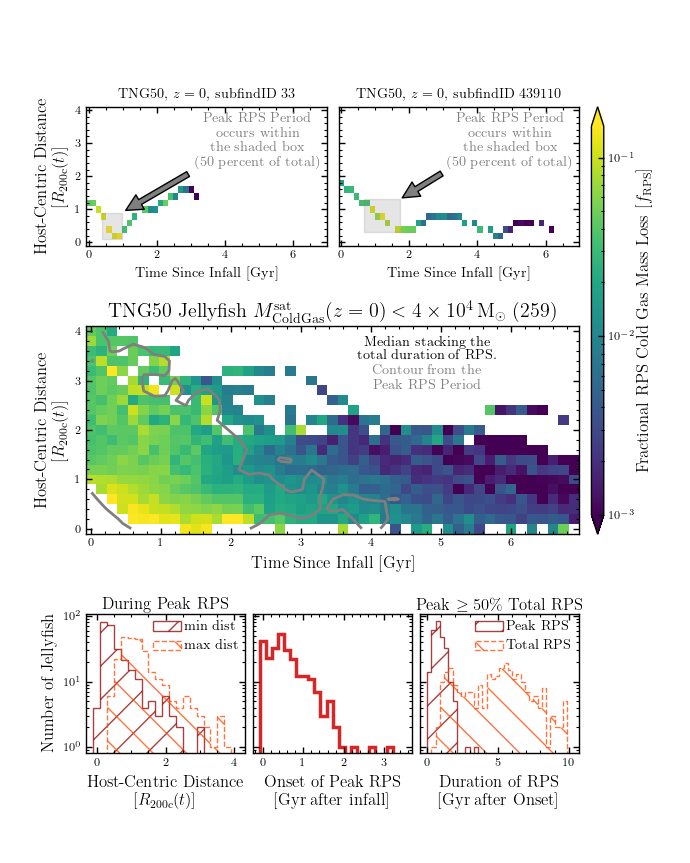

grp_key 00000327 has no infall index
grp_key 00167445 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00198258 has no infall index
grp_key 00275670 has no infall index
grp_key 00282873 has no infall index
grp_key 00301010 has no infall index
grp_key 00000327 has no infall index
grp_key 00167445 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00198258 has no infall index
grp_key 00275670 has no infall index
grp_key 00282873 has no infall index
grp_key 00301010 has no infall index
y_min 16/84/med: 0.22 1.04 0.42
y_max 16/84/med: 0.75 1.86 1.15


In [30]:
tau_dict = TNG50_dict[jel_key][nogas_key].tau_dict

fig = plt.figure(figsize=(figsizewidth, figsizewidth*1.25))

gs0 = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1., 0.025], height_ratios=[0.67, 1.0, 0.67], hspace=0.5)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,0])

gridspec_label_kwargs = dict(fontsize='small')

ax1 = fig.add_subplot(gs00[0])
ax1.set_ylabel(HCDn_label_alt)
ax1.set_xlabel(Tsinceinfall_label, **gridspec_label_kwargs)

subfindID = 33
fig, ax1, _ = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, ax=ax1, labels=False)
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax1.set_title(title, **gridspec_label_kwargs)

ax2 = fig.add_subplot(gs00[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
subfindID = 439110
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax2.set_xlabel(Tsinceinfall_label, **gridspec_label_kwargs)
fig, ax2, h = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, labels=False, ax=ax2)
ax2.set_title(title, **gridspec_label_kwargs)

ax3 = fig.add_subplot(gs0[1,0])
Sim = TNG50_dict[jel_key][nogas_key]
_, ax3 = plot_fracRPSloss_stack(Sim, ax=ax3, cbar=False, alt_ylabel=True)
text = 'Median stacking the \n total duration of RPS.'
ax3.text(4.8, 3.9, text, ha='center', va='top', ma='center', **gridspec_label_kwargs)
text = 'Contour from the \n Peak RPS Period ' #\n (50 percent of total)'
ax3.text(4.8, 3.3, text, ha='center', va='top', ma='center', color='tab:gray', **gridspec_label_kwargs)

gs20 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2,0])
ax4 = fig.add_subplot(gs20[0])
ax5 = fig.add_subplot(gs20[1], sharey=ax4)
ax6 = fig.add_subplot(gs20[2], sharey=ax5)
axs = [ax4, ax5, ax6]

Sim = TNG50_dict[jel_key][nogas_key]
tau_dict = Sim.tau_dict
stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals = calc_stacked_fracRPS(tau_dict)

mask = x_min_vals != -1

peakRPS_len = x_max_vals[mask] - x_min_vals[mask]

axs[0].set_ylabel(r'Number of Jellyfish')
#axs[0].set_yscale('log')

histkwargs_ymins = {**hist_kwargs, 'hatch':'/', 'color':'darkred', 'alpha':0.75, 'label':r'min dist', 'ls':'-'}
histkwargs_ymaxs = {**hist_kwargs, 'hatch':'\\', 'color':'orangered', 'alpha':0.75, 'label':r'max dist', 'ls':'--'}

ax = axs[0]
ax.hist(y_min_vals[mask], bins=y_bins, **histkwargs_ymins)
ax.hist(y_max_vals[mask], bins=y_bins, **histkwargs_ymaxs)
ax.legend(fontsize='small') #bbox_to_anchor=(0.5,1.01), loc='lower center', ncol=2)
ax.set_xlabel(HCDn_label_alt)
ax.set_yscale('log')
ax.text(0.5, 1.01, 'During Peak RPS', va='bottom', ha='center', ma='center', transform=ax.transAxes)
ymin_16 = np.percentile(y_min_vals[mask], 16)
ymin_84 = np.percentile(y_min_vals[mask], 84)
ymin_med = np.median(y_min_vals[mask])
print('y_min 16/84/med: %.2f %.2f %.2f'%(ymin_16, ymin_84, ymin_med))
ymax_16 = np.percentile(y_max_vals[mask], 16)
ymax_84 = np.percentile(y_max_vals[mask], 84)
ymax_med = np.median(y_max_vals[mask])
print('y_max 16/84/med: %.2f %.2f %.2f'%(ymax_16, ymax_84, ymax_med))


ax = axs[1]
plt.setp(ax.get_yticklabels(), visible=False)
binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = x_min_vals[mask].max() + binwidth/2.0
bins = np.arange(bin_start, bin_end, binwidth)
ax.hist(x_min_vals[mask], bins=bins, **Sim.histkwargs)
ax.set_xlabel('Onset of Peak RPS \n [Gyr after infall]')
text = 'TNG50 Jellyfish, \n' + r'$M_{\rm ColdGas}^{\rm sat}(z=0) = 0$'
#ax.text(0.5, 1.01, text, va='bottom', ha='center', ma='center', transform=ax.transAxes)

ax = axs[2]
plt.setp(ax.get_yticklabels(), visible=False)
binwidth = 0.30
bin_start = 0.0
bin_end = 10.5
bins = np.arange(bin_start, bin_end, binwidth)
histkwargs_peakRPS = histkwargs_ymins.copy()
histkwargs_peakRPS['label'] = 'Peak RPS'
ax.hist(peakRPS_len, bins=bins, **histkwargs_peakRPS)
ax.text(0.5, 1.01, r'Peak $\geq50\%$ Total RPS', va='bottom', ha='center', ma='center', transform=ax.transAxes)

totalRPS = tau_dict[tstrip_key][mask]
histkwargs_totalRPS = histkwargs_ymaxs.copy()
histkwargs_totalRPS['label'] = r'Total RPS'
ax.hist(totalRPS, bins=bins, **histkwargs_totalRPS)
ax.legend(fontsize='small') #bbox_to_anchor=(0.5,1.01), loc='lower center')
ax.set_xlabel('Duration of RPS \n [Gyr after Onset]')
#fig.savefig(direc_PP + 'fig9c.pdf', bbox_inches='tight')


gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,1])
ax7 = fig.add_subplot(gs01[:-1])
cbar = fig.colorbar(h, cax=ax7, **cbar_kwargs)
cbar.set_label(cbar_label, labelpad=0)


fname = '%s_fractionalRPS_multipanel.pdf'%Sim.save_label
#fig.savefig(direc_PP + fname, bbox_inches='tight')


<IPython.core.display.Javascript object>


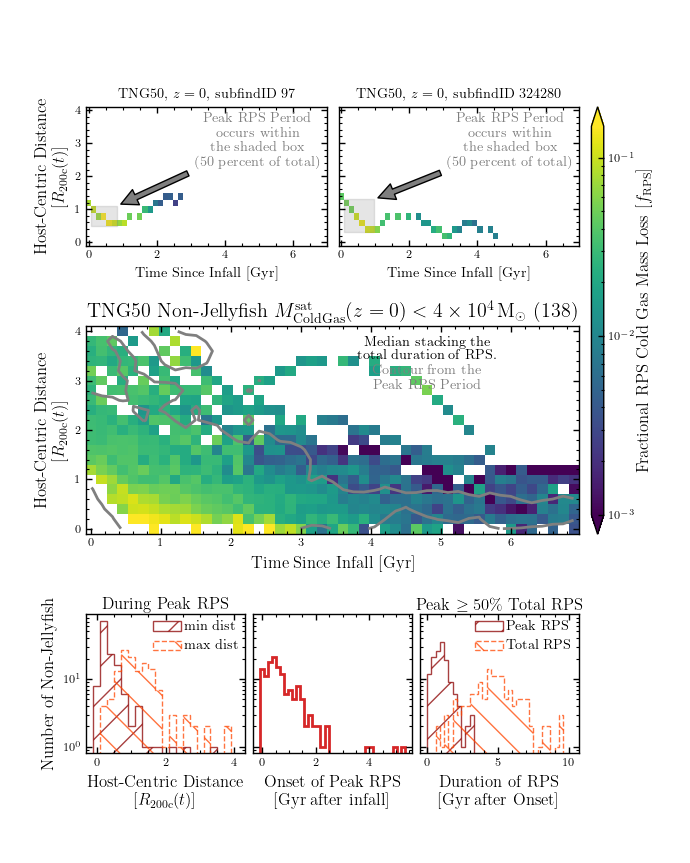

grp_key 00063908 has no infall index
grp_key 00064192 has no infall index
grp_key 00096787 has no infall index
grp_key 00096789 has no infall index
grp_key 00117361 has no infall index
grp_key 00143937 has no infall index
grp_key 00143952 has no infall index
grp_key 00167437 has no infall index
grp_key 00167438 has no infall index
grp_key 00167453 has no infall index
grp_key 00167459 has no infall index
grp_key 00167460 has no infall index
grp_key 00167466 has no infall index
grp_key 00167498 has no infall index
grp_key 00167504 has no infall index
grp_key 00167691 has no infall index
grp_key 00167811 has no infall index
grp_key 00229942 has no infall index
grp_key 00229948 has no infall index
grp_key 00242823 has no infall index
grp_key 00242824 has no infall index
grp_key 00242825 has no infall index
grp_key 00242837 has no infall index
grp_key 00242845 has no infall index
grp_key 00253876 has no infall index
grp_key 00255612 has no infall index
grp_key 00264957 has no infall index
g

/tmp/ipykernel_51045/3363828333.py:110: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(direc_PP + fname, bbox_inches='tight')


In [31]:
tau_dict = TNG50_dict[non_key][nogas_key].tau_dict

fig = plt.figure(figsize=(figsizewidth, figsizewidth*1.25))

gs0 = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[1., 0.025], height_ratios=[0.67, 1.0, 0.67], hspace=0.5)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,0])

gridspec_label_kwargs = dict(fontsize='small')

ax1 = fig.add_subplot(gs00[0])
ax1.set_ylabel(HCDn_label_alt)
ax1.set_xlabel(Tsinceinfall_label, **gridspec_label_kwargs)

subfindID = 97
fig, ax1, _ = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, ax=ax1, labels=False)
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax1.set_title(title, **gridspec_label_kwargs)

ax2 = fig.add_subplot(gs00[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
subfindID = 324280
title = r'TNG50, $z=0$, subfindID %d'%(subfindID)
ax2.set_xlabel(Tsinceinfall_label, **gridspec_label_kwargs)
fig, ax2, h = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=False, labels=False, ax=ax2)
ax2.set_title(title, **gridspec_label_kwargs)

ax3 = fig.add_subplot(gs0[1,0])
Sim = TNG50_dict[non_key][nogas_key]
_, ax3 = plot_fracRPSloss_stack(Sim, ax=ax3, cbar=False, alt_ylabel=True)
text = 'Median stacking the \n total duration of RPS.'
ax3.text(4.8, 3.9, text, ha='center', va='top', ma='center', **gridspec_label_kwargs)
text = 'Contour from the \n Peak RPS Period ' #\n (50 percent of total)'
ax3.text(4.8, 3.3, text, ha='center', va='top', ma='center', color='tab:gray', **gridspec_label_kwargs)

gs20 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2,0])
ax4 = fig.add_subplot(gs20[0])
ax5 = fig.add_subplot(gs20[1], sharey=ax4)
ax6 = fig.add_subplot(gs20[2], sharey=ax5)
axs = [ax4, ax5, ax6]

Sim = TNG50_dict[non_key][nogas_key]
tau_dict = Sim.tau_dict
stacked_result, stacked_result_frac, x_min_vals, x_max_vals, y_min_vals, y_max_vals = calc_stacked_fracRPS(tau_dict)

mask = x_min_vals != -1

peakRPS_len = x_max_vals[mask] - x_min_vals[mask]

axs[0].set_ylabel(r'Number of Non-Jellyfish')
#axs[0].set_yscale('log')

histkwargs_ymins = {**hist_kwargs, 'hatch':'/', 'color':'darkred', 'alpha':0.75, 'label':r'min dist', 'ls':'-'}
histkwargs_ymaxs = {**hist_kwargs, 'hatch':'\\', 'color':'orangered', 'alpha':0.75, 'label':r'max dist', 'ls':'--'}

ax = axs[0]
ax.hist(y_min_vals[mask], bins=y_bins, **histkwargs_ymins)
ax.hist(y_max_vals[mask], bins=y_bins, **histkwargs_ymaxs)
ax.legend(fontsize='small') #bbox_to_anchor=(0.5,1.01), loc='lower center', ncol=2)
ax.set_xlabel(HCDn_label_alt)
ax.set_yscale('log')
ax.text(0.5, 1.01, 'During Peak RPS', va='bottom', ha='center', ma='center', transform=ax.transAxes)
ymin_16 = np.percentile(y_min_vals[mask], 16)
ymin_84 = np.percentile(y_min_vals[mask], 84)
ymin_med = np.median(y_min_vals[mask])
print('y_min 16/84/med: %.2f %.2f %.2f'%(ymin_16, ymin_84, ymin_med))
ymax_16 = np.percentile(y_max_vals[mask], 16)
ymax_84 = np.percentile(y_max_vals[mask], 84)
ymax_med = np.median(y_max_vals[mask])
print('y_max 16/84/med: %.2f %.2f %.2f'%(ymax_16, ymax_84, ymax_med))


ax = axs[1]
plt.setp(ax.get_yticklabels(), visible=False)
binwidth = 0.15
bin_start = -binwidth/2.0
bin_end = x_min_vals[mask].max() + binwidth/2.0
bins = np.arange(bin_start, bin_end, binwidth)
ax.hist(x_min_vals[mask], bins=bins, **Sim.histkwargs)
ax.set_xlabel('Onset of Peak RPS \n [Gyr after infall]')
text = 'TNG50 Non-Jellyfish, \n' + r'$M_{\rm ColdGas}^{\rm sat}(z=0) = 0$'
#ax.text(0.5, 1.01, text, va='bottom', ha='center', ma='center', transform=ax.transAxes)

ax = axs[2]
plt.setp(ax.get_yticklabels(), visible=False)
binwidth = 0.30
bin_start = 0.0
bin_end = 10.5
bins = np.arange(bin_start, bin_end, binwidth)
histkwargs_peakRPS = histkwargs_ymins.copy()
histkwargs_peakRPS['label'] = 'Peak RPS'
ax.hist(peakRPS_len, bins=bins, **histkwargs_peakRPS)
ax.text(0.5, 1.01, r'Peak $\geq50\%$ Total RPS', va='bottom', ha='center', ma='center', transform=ax.transAxes)

totalRPS = tau_dict[tstrip_key][mask]
histkwargs_totalRPS = histkwargs_ymaxs.copy()
histkwargs_totalRPS['label'] = r'Total RPS'
ax.hist(totalRPS, bins=bins, **histkwargs_totalRPS)
ax.legend(fontsize='small') #bbox_to_anchor=(0.5,1.01), loc='lower center')
ax.set_xlabel('Duration of RPS \n [Gyr after Onset]')
#fig.savefig(direc_PP + 'fig9c.pdf', bbox_inches='tight')


gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,1])
ax7 = fig.add_subplot(gs01[:-1])
cbar = fig.colorbar(h, cax=ax7, **cbar_kwargs)
cbar.set_label(cbar_label, labelpad=0)

fname = '%s_fractionalRPS_multipanel.pdf'%Sim.save_label
fig.savefig(direc_PP + fname, bbox_inches='tight')


<IPython.core.display.Javascript object>


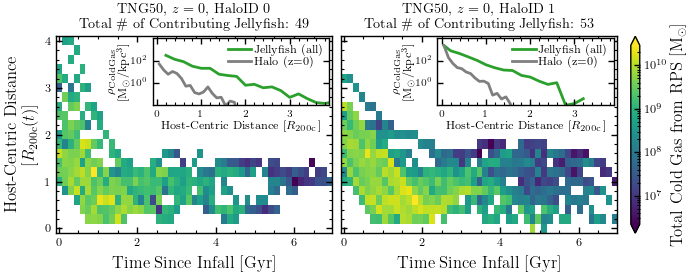

grp_key 00000327 has no infall index
Total amount of deposited gas is 11.90 log[Msun]


<IPython.core.display.Javascript object>


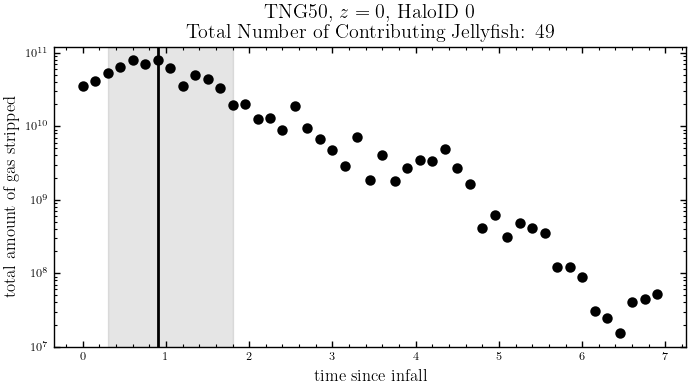

<IPython.core.display.Javascript object>


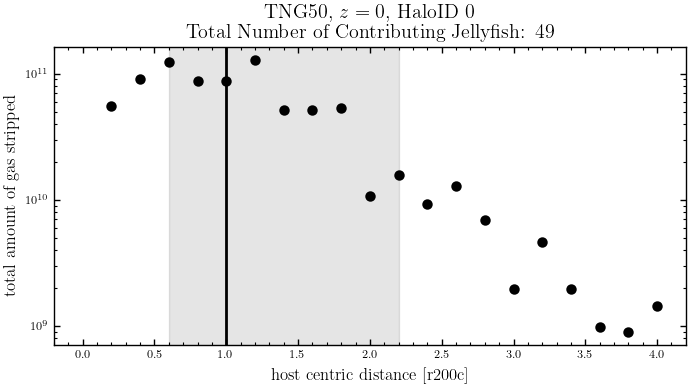

Total amount of deposited gas is 11.98 log[Msun]


/tmp/ipykernel_51045/4175600763.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


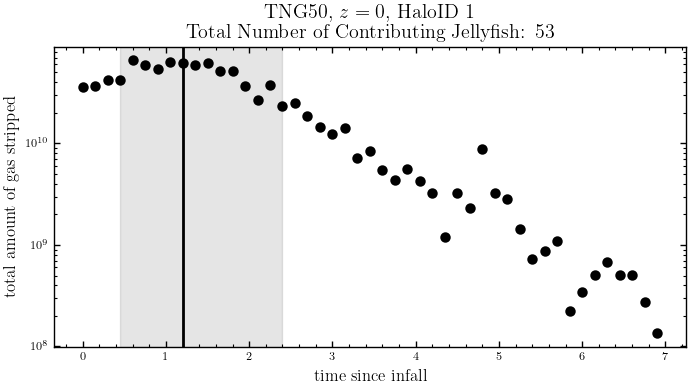

<IPython.core.display.Javascript object>


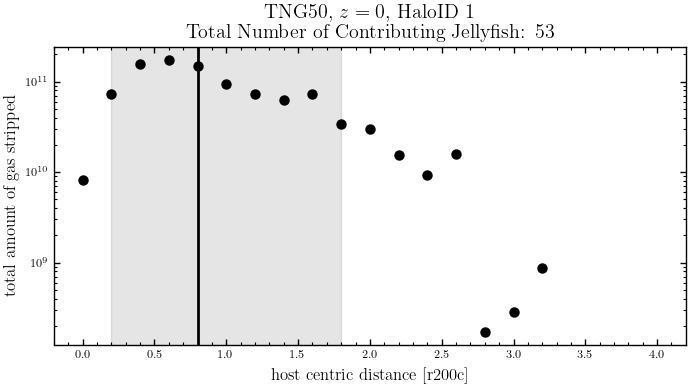

In [32]:
Sim = TNG50_dict[jel_key][tot_key]
tau_dict = Sim.tau_dict
M200cz0 = tau_dict[M200cz0_key]
M200cz0_unique = np.unique(M200cz0)[::-1]

fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizewidth/2.5), sharey=True)

halo_index = 0
ax = axs[halo_index]
halomass = M200cz0_unique[halo_index]
fig, ax, _, Njelly = plot_fracRPSloss_halo(m200cz0_lolim=halomass, m200cz0_hilim=halomass,
                          tau_dict=tau_dict, grp_dict=grp_dict,
                          plot_profiles_flag=True, ax=ax, labels=False)
title = (r'TNG50, $z=0$, HaloID %d'%(halo_index) 
         + '\n Total \# of Contributing Jellyfish: %d'%(Njelly))

ax.set_ylabel(HCDn_label_alt)
ax.set_xlabel(Tsinceinfall_label)
ax.set_title(title, fontsize='small')

halo_index = 1
ax = axs[halo_index]
halomass = M200cz0_unique[halo_index]
fig, ax, h, Njelly = plot_fracRPSloss_halo(m200cz0_lolim=halomass, m200cz0_hilim=halomass,
                          tau_dict=tau_dict, grp_dict=grp_dict,
                          plot_profiles_flag=True, ax=ax, labels=False)
title = (r'TNG50, $z=0$, HaloID %d'%(halo_index) 
         + '\n Total \# of Contributing Jellyfish: %d'%(Njelly))
cbar = fig.colorbar(h, ax=ax, extend='both')
cbar.set_label(cbar_halo_label, labelpad=1)
ax.set_xlabel(Tsinceinfall_label)
ax.set_title(title, fontsize='small')

fname = '%s_halos_totalRPS.pdf'%Sim.save_label
#fig.savefig(direc_PP + fname, bbox_inches='tight')

<IPython.core.display.Javascript object>


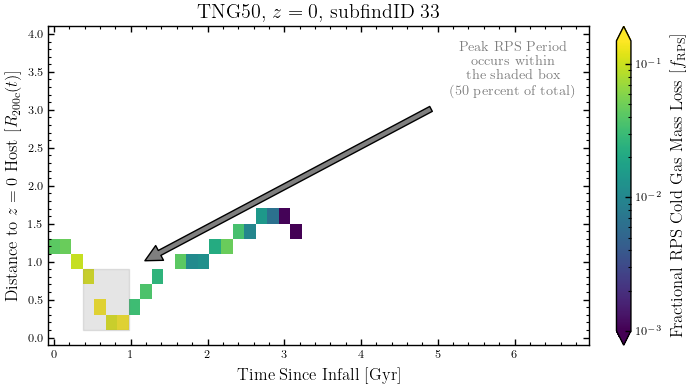

<IPython.core.display.Javascript object>


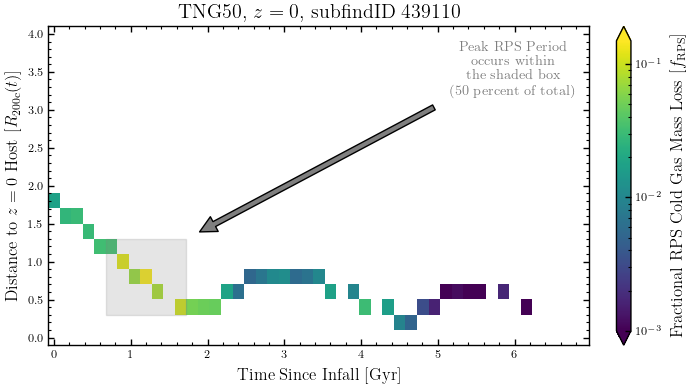

In [33]:

tau_dict = TNG50_dict[jel_key][nogas_key].tau_dict
subfindIDs = [33, 439110]
for subfindID in subfindIDs:
    fig, ax = plot_fracRPSloss_subhalo(subfindID, tau_dict, savefig=savefig)



In [34]:
centrals_GRP = load_grpdict(sim, taudict_key, centrals=True)
centrals_keys = np.array(list(centrals_GRP.keys()))


In [35]:
centrals_CGMCGM_z0 = np.zeros(centrals_keys.size, dtype=float)
centrals_M200c_z0 = centrals_CGMCGM_z0.copy()
inspected_RPSCGM_all = centrals_CGMCGM_z0.copy()
jellyfish_RPSCGM_all = centrals_CGMCGM_z0.copy()

tau_dict_ins = TNG50_dict[ins_key][tot_key].tau_dict
tau_dict_jel = TNG50_dict[jel_key][tot_key].tau_dict
grp_dict = grp_dict

for central_i, central_key in enumerate(centrals_keys):
    group = centrals_GRP[central_key]
    centrals_CGMCGM_z0[central_i] = np.sum(group['mass_shells'][0][1:])
    centrals_M200c_z0[central_i] = group['HostGroup_M_Crit200']
    m200c = group['HostGroup_M_Crit200']
    
    # inspected
    m200cz0 = tau_dict_ins[M200cz0_key]
    taudict_indices = np.where(m200cz0 == m200c)[0]
    if taudict_indices.size > 0:
        result = np.zeros([taudict_indices.size, y_bins.size-1, x_bins.size-1], dtype=float)

        for i, taudict_index in enumerate(taudict_indices):
            result[i,:,:] = calc_fracRPSloss(taudict_index, tau_dict_ins, grp_dict, 
                                                         norm=False, peakRPS=False)
        hist = np.sum(result, axis=0)
        tot = np.sum(hist)
    else:
        tot = 0
    inspected_RPSCGM_all[central_i] = tot
    
    # jellyfish 
    m200cz0 = tau_dict_jel[M200cz0_key]
    taudict_indices = np.where(m200cz0 == m200c)[0]
    if taudict_indices.size > 0:
        result = np.zeros([taudict_indices.size, y_bins.size-1, x_bins.size-1], dtype=float)

        for i, taudict_index in enumerate(taudict_indices):
            result[i,:,:] = calc_fracRPSloss(taudict_index, tau_dict_jel, grp_dict, 
                                                         norm=False, peakRPS=False)
        hist = np.sum(result, axis=0)
        tot = np.sum(hist)
    else:
        tot = 0
    jellyfish_RPSCGM_all[central_i] = tot
    


grp_key 00000327 has no infall index
grp_key 00000327 has no infall index
grp_key 00063908 has no infall index
grp_key 00064192 has no infall index
grp_key 00096787 has no infall index
grp_key 00096789 has no infall index
grp_key 00117361 has no infall index
grp_key 00143937 has no infall index
grp_key 00143952 has no infall index
grp_key 00167437 has no infall index
grp_key 00167438 has no infall index
grp_key 00167445 has no infall index
grp_key 00167453 has no infall index
grp_key 00167459 has no infall index
grp_key 00167460 has no infall index
grp_key 00167466 has no infall index
grp_key 00167498 has no infall index
grp_key 00167504 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00167691 has no infall index
grp_key 00167811 has no infall index
grp_key 00167445 has no infall index
grp_key 00167546 has no infall index
grp_key 00167553 has no infall index
grp_key 00198258 has no infall index
grp_key 00198258 has no infall index
g

<IPython.core.display.Javascript object>


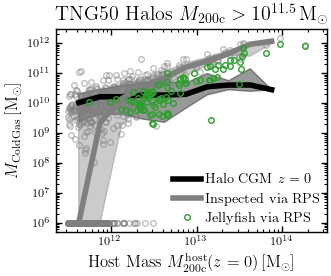

/tmp/ipykernel_51045/2017072667.py:2: RuntimeWarning: divide by zero encountered in log10
  bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(x), np.log10(y), x_binwidth)


In [36]:
def plot_med_percs_outliers(ax, x, y, x_binwidth, color, label):
    bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(x), np.log10(y), x_binwidth)
    
    #ax.plot(x, y, c=color, fillstyle='none', ms=4, alpha=0.5, mew=1.0)
    ax.plot(10.**(bin_cents), 10.**(y_50s), c=color, ls='-', lw=4, marker='None', label=label, zorder=3)
    ax.fill_between(10.**(bin_cents), 10.**(y_16s), 10.**(y_84s), color=color, alpha=0.4, zorder=1)
    
    return ax

fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.2))
ax.set_xscale('log')
ax.set_yscale('log')
#kwargs = dict(fillstyle='none', ms=4, mew=1.)
indices = inspected_RPSCGM_all < 1.0e6
inspected_RPSCGM_all[indices] = 1.0e6
ax = plot_med_percs_outliers(ax, centrals_M200c_z0, centrals_CGMCGM_z0, mass_binwidth, color='black', label=r'Halo CGM $z=0$')
ax = plot_med_percs_outliers(ax, centrals_M200c_z0, inspected_RPSCGM_all, mass_binwidth,  label=r'Inspected via RPS', color='tab:gray')
ax.plot(centrals_M200c_z0, inspected_RPSCGM_all, c='tab:gray', fillstyle='none', ms=4, alpha=0.5, mew=1.0)
#ax = plot_med_percs_outliers(ax, centrals_M200c_z0, jellyfish_RPSCGM_all, mass_binwidth, label=r'Jellyfish via RPS', color='tab:green')
ax.plot(centrals_M200c_z0, jellyfish_RPSCGM_all, fillstyle='none', ms=4, mew=1., label=r'Jellyfish via RPS', color='tab:green', zorder=3.1)
#plt.plot(centrals_M200c_z0, centrals_CGMCGM_z0, label=r'Halo CGM $z=0$', color='black', **kwargs)
#plt.plot(centrals_M200c_z0, jellyfish_RPSCGM_all,  **kwargs, zorder=3)
#plt.plot(centrals_M200c_z0, inspected_RPSCGM_all, label=r'Inspected via RPS', color='tab:gray', **kwargs, alpha=0.8)
ax.set_xlabel(r'Host Mass $M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_{\odot}}]$')
ax.set_ylabel(r'$M_{\rm ColdGas}\, [{\rm M_{\odot}}]$')
ax.legend(fontsize='small')
ax.set_title(r'TNG50 Halos $M_{\rm 200c} > 10^{11.5}\, {\rm M_{\odot}}$')
fname = r'TNG50-1_haloCGM_jellyfishRPS_inspectedRPS.pdf'
#plt.savefig(direc_PP + fname, bbox_inches='tight')